# Vision por computadora 2

Alumnos:

- Julian Ferreira
- Amilcar Rincon Charris
- Paola Cartala

Configuración e Importación de Librerías

In [1]:
import os
import shutil
import random
import yaml
import math
from collections import Counter

import cv2
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import albumentations as A

In [2]:
dataset_dir = 'dataset'

if os.path.exists(os.path.join(dataset_dir, 'data.yaml')):
    print(f"El dataset ya se encuentra en la carpeta '{dataset_dir}'. Saltando descarga.")
    path = dataset_dir
else:
    print(f"Dataset no encontrado en '{dataset_dir}'. Procediendo a la descarga...")

    download_path = kagglehub.dataset_download("orvile/x-ray-baggage-anomaly-detection")
    shutil.copytree(download_path, dataset_dir, dirs_exist_ok=True)
    print(f"Dataset descargado en: '{dataset_dir}'")
    path = dataset_dir

Dataset no encontrado en 'dataset'. Procediendo a la descarga...


100%|██████████| 133M/133M [00:00<00:00, 207MB/s]

Extracting files...


Dataset descargado en: 'dataset'


In [3]:
base_dir = path
train_images_dir = os.path.join(base_dir, 'train/images')
train_labels_dir = os.path.join(base_dir, 'train/labels')
valid_images_dir = os.path.join(base_dir, 'valid/images')
valid_labels_dir = os.path.join(base_dir, 'valid/labels')

with open(os.path.join(base_dir, 'data.yaml'), 'r') as file:
    data_yaml = yaml.safe_load(file)
    class_names = data_yaml['names']
    print("Clases del dataset:", class_names)

Clases del dataset: ['0', '1', '2', '3', '4']


## Primera entrega: EDA

### 1. Visualización de Muestras del Dataset

In [4]:
def visualize_image_with_bboxes(image_dir, label_dir, image_name, class_names):
    """
    Muestra una imagen con sus bounding boxes.
    """
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    ax.set_title(f"Visualización de: {image_name}")

    # bounding boxes
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width_norm, height_norm = map(float, line.split())

                # desnormalizar coordenadas
                box_w = width_norm * w
                box_h = height_norm * h
                x_min = (x_center * w) - (box_w / 2)
                y_min = (y_center * h) - (box_h / 2)

                # rectangulo
                rect = patches.Rectangle((x_min, y_min), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

                # etiqueta de clase
                class_name = class_names[int(class_id)]
                plt.text(x_min, y_min, class_name, color='white', fontsize=12, backgroundcolor='red')

    plt.axis('off')
    plt.show()

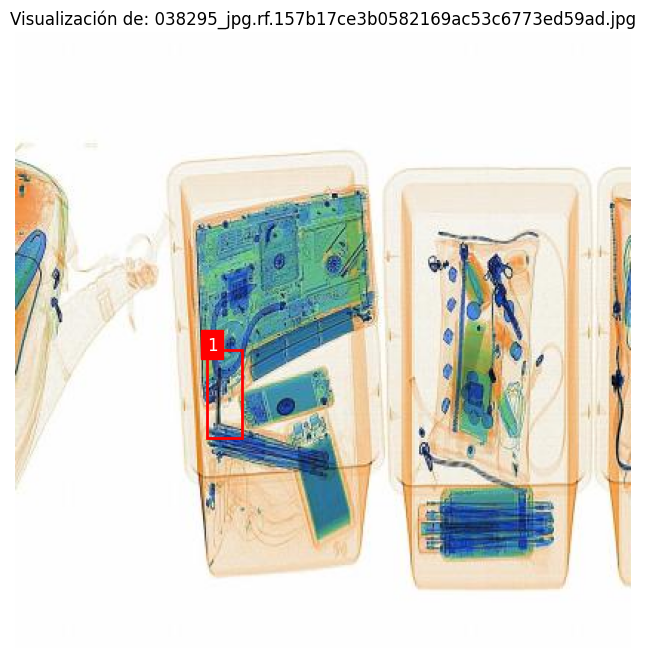

In [5]:
image_files = [f for f in os.listdir(train_images_dir) if f.endswith('.jpg')]
random_image = random.choice(image_files)
visualize_image_with_bboxes(train_images_dir, train_labels_dir, random_image, class_names)

In [ ]:
train_images_dir
train_labels_dir
valid_images_dir
valid_labels_dir

'dataset\\valid/labels'

In [6]:
sizes = {}
for img in os.listdir(train_images_dir):
    img_path = os.path.join(train_images_dir, img)
    img = cv2.imread(img_path)
    if img.shape in sizes:
        sizes[img.shape] += 1
    else:
        sizes[img.shape] = 1
for img in os.listdir(valid_images_dir):
    img_path = os.path.join(valid_images_dir, img)
    img = cv2.imread(img_path)
    if img.shape in sizes:
        sizes[img.shape] += 1
    else:
        sizes[img.shape] = 1

In [ ]:
print(f"Las imagenes presentes en el dataset presentan las siguientes dimenciones: {sizes}")

Las imagenes presentes en el dataset presentan las siguientes dimenciones: {(416, 416, 3): 7947}


### 2. Análisis de Bounding Boxes

In [7]:
def get_all_bboxes(label_dir):
    """
    Recorre todos los archivos de etiquetas y extrae la información de las bounding boxes.
    """
    bboxes = []
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as f:
                for line in f:
                    parts = list(map(float, line.split()))
                    bboxes.append(parts)
    return np.array(bboxes)

In [8]:
all_train_bboxes = get_all_bboxes(train_labels_dir)
print(f"Total de Bounding Boxes en el set de entrenamiento: {len(all_train_bboxes)}")

classes = all_train_bboxes[:, 0].astype(int)
centers_x = all_train_bboxes[:, 1]
centers_y = all_train_bboxes[:, 2]
widths = all_train_bboxes[:, 3]
heights = all_train_bboxes[:, 4]

Total de Bounding Boxes en el set de entrenamiento: 6181


#### 2.1. Distribución de Tamaños (Área)

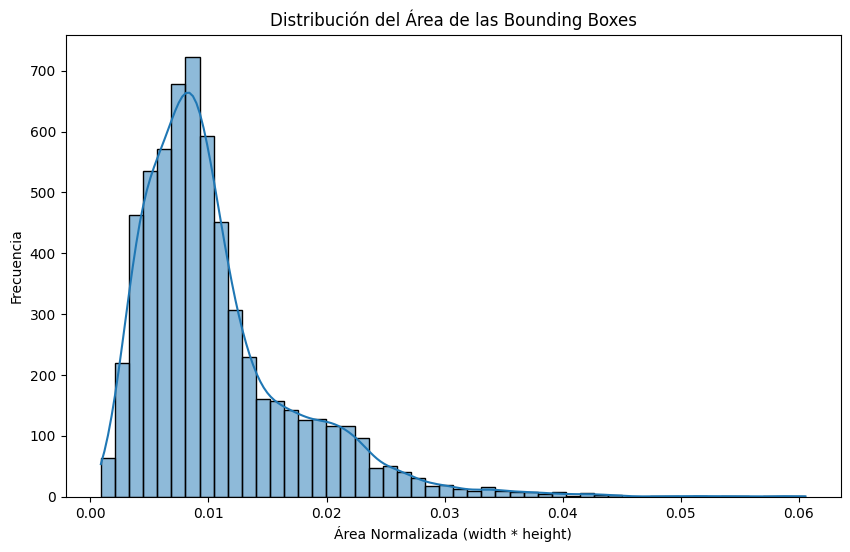

In [9]:
areas = widths * heights
plt.figure(figsize=(10, 6))
sns.histplot(areas, bins=50, kde=True)
plt.title('Distribución del Área de las Bounding Boxes')
plt.xlabel('Área Normalizada (width * height)')
plt.ylabel('Frecuencia')
plt.show()

Lo primero que salta a la vista es que casi todos los objetos que tenemos que encontrar son bastante chicos. Si vemos el gráfico, la mayoría de las cajitas tienen un área bastante pequeña, menos de 0.2. Hay algunos objetos grandes, pero son pocos.

#### 2.2. Distribución de Aspect Ratios

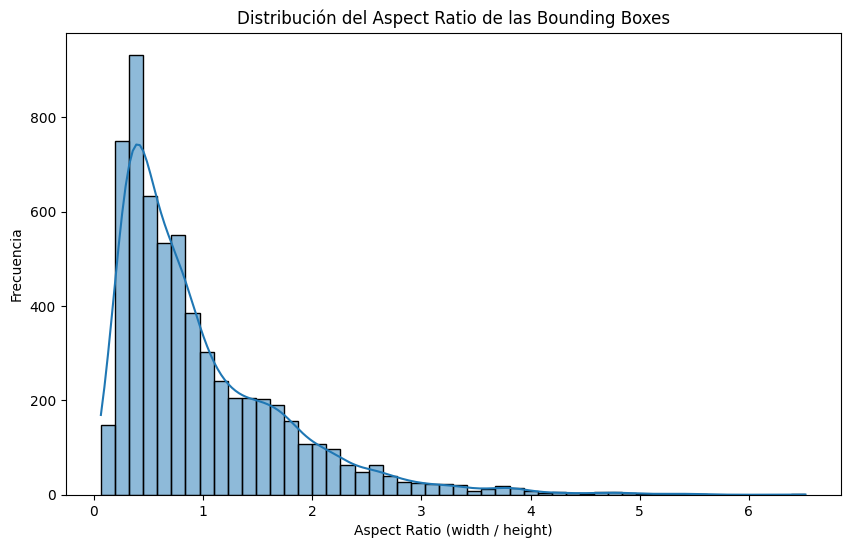

In [10]:
aspect_ratios = widths / heights
plt.figure(figsize=(10, 6))
sns.histplot(aspect_ratios, bins=50, kde=True)
plt.title('Distribución del Aspect Ratio de las Bounding Boxes')
plt.xlabel('Aspect Ratio (width / height)')
plt.ylabel('Frecuencia')
plt.show()

Acá se ve que los objetos no tienen una única forma. Hay un montón que son más o menos cuadrados (el pico en 1.0), pero también hay bastantes que son más altos que anchos, o más anchos que bajos.

#### 2.3. Mapa de Calor de Ubicaciones

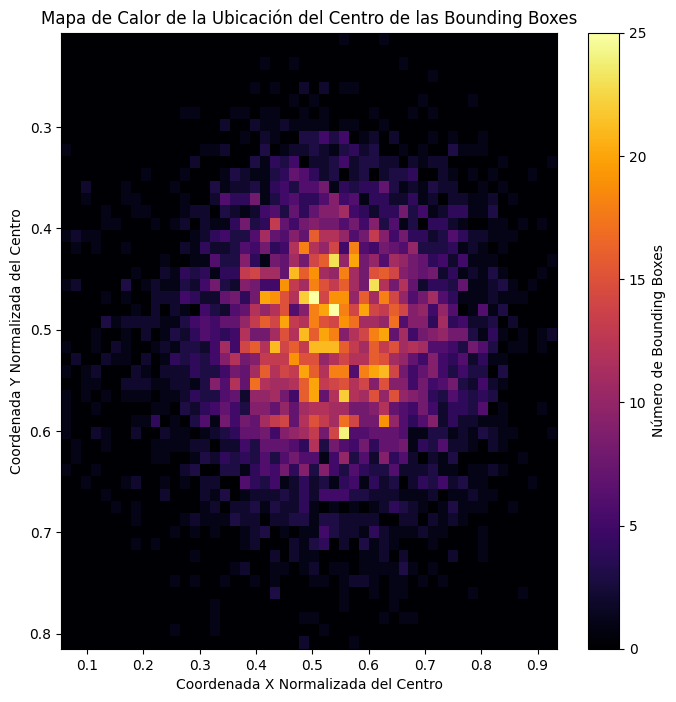

In [11]:
plt.figure(figsize=(8, 8))
plt.hist2d(centers_x, centers_y, bins=50, cmap='inferno')
plt.colorbar(label='Número de Bounding Boxes')
plt.title('Mapa de Calor de la Ubicación del Centro de las Bounding Boxes')
plt.xlabel('Coordenada X Normalizada del Centro')
plt.ylabel('Coordenada Y Normalizada del Centro')
plt.gca().invert_yaxis()

Este gráfico es el más claro de todos. Casi todos los objetos aparecen en el centro de la imagen. A medida que te vas a los bordes, no hay casi nada. Tiene lógica, porque las cosas pasan por el medio del escáner.

### 2.4 Analisis de distribucion de color por clase

Clases: ['0', '1', '2', '3', '4']


Procesando etiquetas: 100%|██████████| 6181/6181 [00:06<00:00, 915.74it/s]


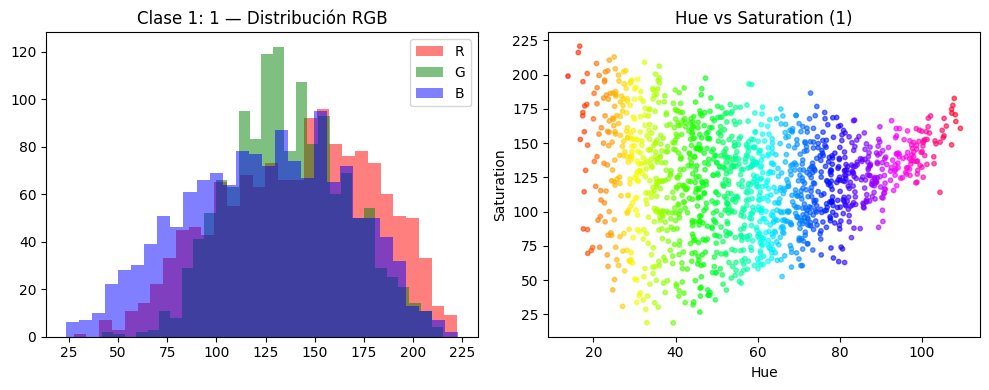

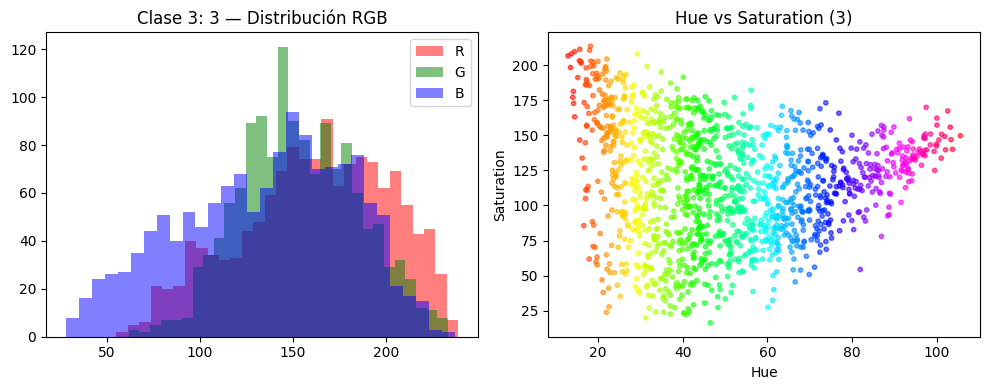

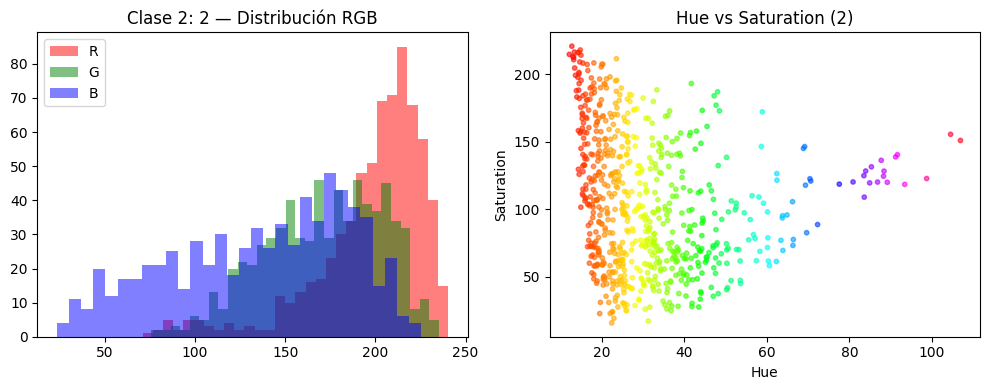

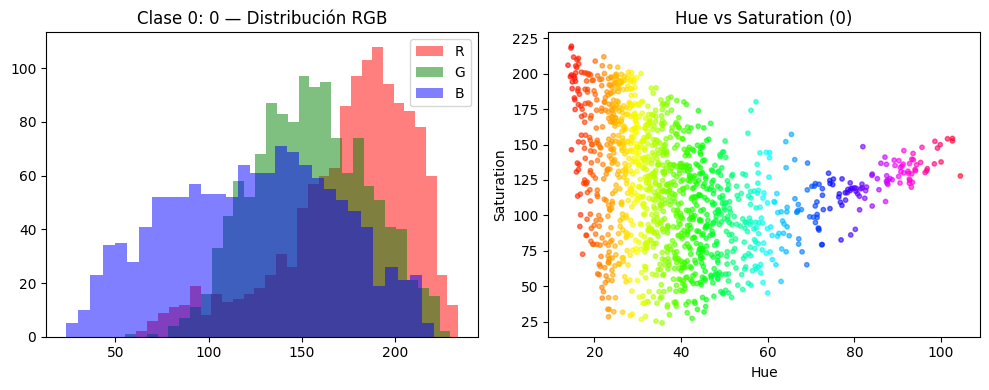

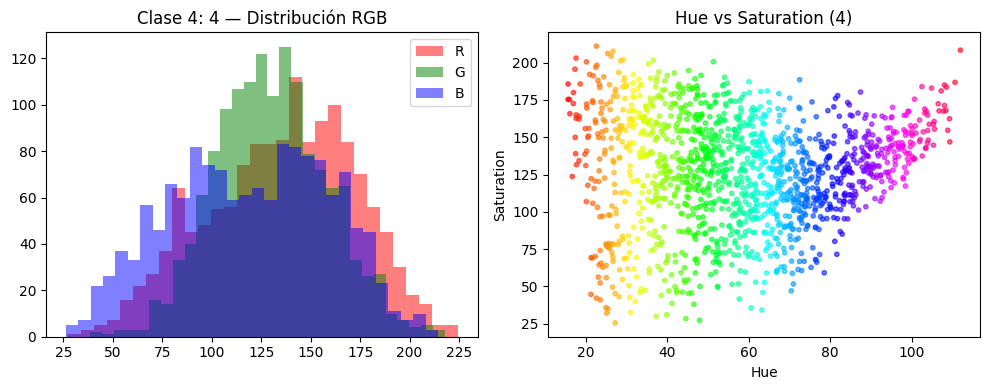

R_mean  G_mean  B_mean  R_std  G_std  B_std  Hue_mean  Sat_mean  Val_mean
1  141.54  136.83  125.23  39.04  29.63  40.73     57.06    122.20    173.65
3  161.35  153.39  135.09  40.02  31.70  45.41     50.30    114.87    190.78
2  198.08  171.14  135.98  30.40  32.61  49.01     31.31    104.44    208.55
0  175.38  154.41  123.52  34.65  30.28  45.09     40.10    118.52    193.51
4  135.46  130.22  119.46  37.23  28.14  39.92     58.32    126.74    166.75

In [12]:
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict

BASE_DIR = Path("dataset")
DATA_YAML = BASE_DIR/"data.yaml"

# Leer nombres de clases
with open(DATA_YAML, 'r') as f:
    names = yaml.safe_load(f)['names']
print("Clases:", names)

# Directorios
img_dir = BASE_DIR/"train/images"
lbl_dir = BASE_DIR/"train/labels"

# Acumuladores
color_data = defaultdict(list)

# Recorrer todas las etiquetas
for lbl_file in tqdm(list(lbl_dir.glob("*.txt")), desc="Procesando etiquetas"):
    img_file = img_dir/f"{lbl_file.stem}.jpg"
    if not img_file.exists():
        img_file = img_dir/f"{lbl_file.stem}.png"
    if not img_file.exists():
        continue

    img = cv2.imread(str(img_file))
    if img is None:
        continue
    h, w, _ = img.shape
    with open(lbl_file, 'r') as f:
        for line in f:
            c, cx, cy, bw, bh = map(float, line.strip().split())
            c = int(c)
            x1, y1 = int((cx - bw/2)*w), int((cy - bh/2)*h)
            x2, y2 = int((cx + bw/2)*w), int((cy + bh/2)*h)
            x1, y1 = max(0,x1), max(0,y1)
            x2, y2 = min(w-1,x2), min(h-1,y2)
            crop = img[y1:y2, x1:x2]
            if crop.size == 0:
                continue
            crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            crop_hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
            # Promedio por canal (RGB + HSV)
            mean_rgb = np.mean(crop_rgb.reshape(-1,3), axis=0)
            mean_hsv = np.mean(crop_hsv.reshape(-1,3), axis=0)
            color_data[c].append((mean_rgb, mean_hsv))

# Convertir a arrays por clase
stats = {}
for c, vals in color_data.items():
    rgbs = np.array([v[0] for v in vals])
    hsvs = np.array([v[1] for v in vals])
    stats[c] = {
        "rgb_mean": np.mean(rgbs, axis=0),
        "rgb_std": np.std(rgbs, axis=0),
        "hsv_mean": np.mean(hsvs, axis=0),
        "hsv_std": np.std(hsvs, axis=0)
    }

# Mostrar histogramas RGB y dispersión Hue–Saturation
for c, vals in color_data.items():
    rgbs = np.array([v[0] for v in vals])
    hsvs = np.array([v[1] for v in vals])
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    axs[0].hist(rgbs[:,0], bins=30, color='r', alpha=0.5, label='R')
    axs[0].hist(rgbs[:,1], bins=30, color='g', alpha=0.5, label='G')
    axs[0].hist(rgbs[:,2], bins=30, color='b', alpha=0.5, label='B')
    axs[0].set_title(f"Clase {c}: {names[c]} — Distribución RGB")
    axs[0].legend()
    axs[1].scatter(hsvs[:,0], hsvs[:,1], s=10, alpha=0.6, c=hsvs[:,0], cmap='hsv')
    axs[1].set_xlabel("Hue")
    axs[1].set_ylabel("Saturation")
    axs[1].set_title(f"Hue vs Saturation ({names[c]})")
    plt.tight_layout()
    plt.show()

# Tabla resumen
import pandas as pd
df_stats = pd.DataFrame.from_dict({
    names[c]: {
        "R_mean": stats[c]["rgb_mean"][0], "G_mean": stats[c]["rgb_mean"][1], "B_mean": stats[c]["rgb_mean"][2],
        "R_std": stats[c]["rgb_std"][0], "G_std": stats[c]["rgb_std"][1], "B_std": stats[c]["rgb_std"][2],
        "Hue_mean": stats[c]["hsv_mean"][0], "Sat_mean": stats[c]["hsv_mean"][1], "Val_mean": stats[c]["hsv_mean"][2]
    } for c in stats.keys()
}, orient="index")
display(df_stats.round(2))


### Visualización del espacio de color H–S por clase

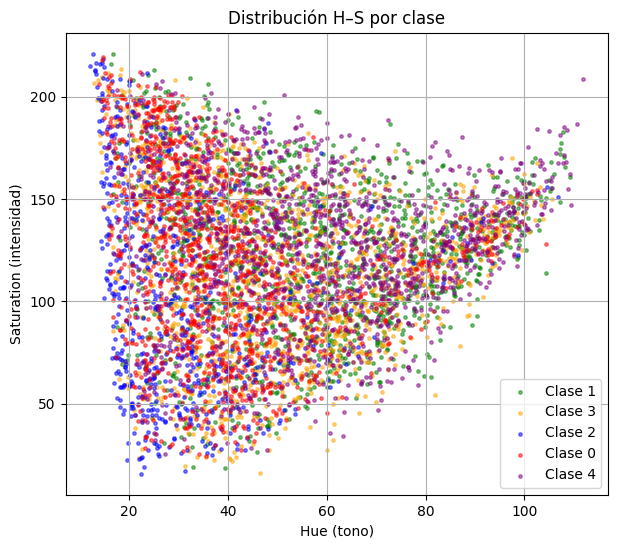

In [13]:
plt.figure(figsize=(7,6))
colors = ['red','green','blue','orange','purple']
for c, vals in color_data.items():
    hsvs = np.array([v[1] for v in vals])
    plt.scatter(hsvs[:,0], hsvs[:,1], s=6, alpha=0.5, color=colors[c], label=f"Clase {c}")

plt.xlabel("Hue (tono)")
plt.ylabel("Saturation (intensidad)")
plt.title("Distribución H–S por clase")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# === Fisher Score por canal ===
def fisher_score(features, labels):
    classes = np.unique(labels)
    overall_mean = np.mean(features)
    num, den = 0, 0
    for c in classes:
        f_c = features[labels==c]
        num += len(f_c) * (np.mean(f_c) - overall_mean)**2
        den += np.sum((f_c - np.mean(f_c))**2)
    return num / (den + 1e-6)

import pandas as pd
labels = []
hsv_means = []
rgb_means = []
for c, vals in color_data.items():
    labels.extend([c]*len(vals))
    rgb_means.extend([v[0] for v in vals])
    hsv_means.extend([v[1] for v in vals])

labels = np.array(labels)
rgb_means = np.array(rgb_means)
hsv_means = np.array(hsv_means)

cols = ['R','G','B','H','S','V']
data = np.concatenate([rgb_means, hsv_means], axis=1)
scores = [fisher_score(data[:,i], labels) for i in range(data.shape[1])]
df_fisher = pd.DataFrame({'Canal':cols, 'Fisher_Score':scores}).sort_values('Fisher_Score', ascending=False)
display(df_fisher.round(3))


Canal  Fisher_Score
5     V         0.328
0     R         0.309
3     H         0.213
1     G         0.191
4     S         0.027
2     B         0.021

El análisis del espacio de color revela que las clases se diferencian principalmente por el brillo (V) y la intensidad del canal rojo (R), mientras que el tono (H) y la saturación (S) tienen poca influencia en la separación. Esto indica que el modelo podría estar aprendiendo patrones basados en la iluminación o el color rojizo más que en las formas o texturas.

### Clasificador logístico rápido con [H, S, V]

              precision    recall  f1-score   support

     Clase 0       0.35      0.43      0.39       385
     Clase 1       0.27      0.15      0.19       418
     Clase 2       0.44      0.34      0.38       210
     Clase 3       0.34      0.32      0.33       414
     Clase 4       0.39      0.54      0.46       428

    accuracy                           0.36      1855
   macro avg       0.36      0.36      0.35      1855
weighted avg       0.35      0.36      0.35      1855



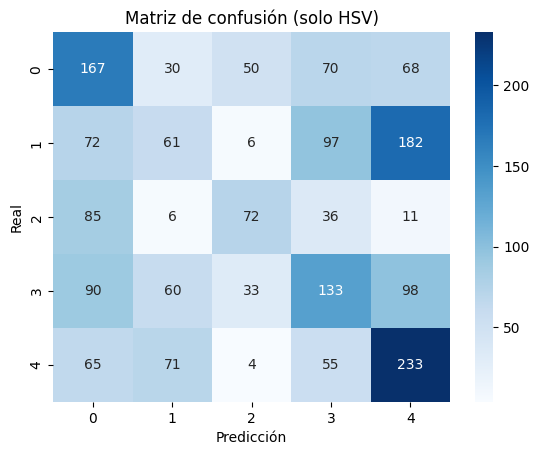

In [15]:
# === Clasificador logístico simple con HSV ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

X = hsv_means
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=[f"Clase {i}" for i in np.unique(y)]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión (solo HSV)")
plt.show()


El clasificador basado únicamente en los valores de color (HSV) alcanzó una precisión global del 36 %, lo que indica una capacidad limitada del color para distinguir las clases. Las clases 0, 2 y 4 muestran un rendimiento algo mejor (f1≈0.4–0.46), mientras que las clases 1 y 3 presentan mayor confusión, con recall y precision bajos. Esto confirma que, aunque el color aporta cierta información (especialmente en brillo y tonalidades rojizas), no es suficiente por sí solo para una discriminación confiable. Por tanto, el modelo a usar debe apoyarse principalmente en características de forma, textura y contorno, reforzando augmentations que reduzcan la dependencia del color y mejoren la robustez visual del entrenamiento.

### 3. Data Augmentation para Balanceo de Clases

In [ ]:
def plot_class_distribution(label_dirs, title, class_names_map):
    """
    Calcula y grafica la distribución de clases a partir de directorios de etiquetas.
    """
    all_classes = []
    if not isinstance(label_dirs, list):
        label_dirs = [label_dirs]

    for label_dir in label_dirs:
        if not os.path.isdir(label_dir):
            print(f"Advertencia: El directorio {label_dir} no existe. Será omitido.")
            continue
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                with open(os.path.join(label_dir, label_file), 'r') as f:
                    for line in f:
                        class_id = int(float(line.split()[0]))
                        all_classes.append(class_id)

    # ocurrencias de cada clase
    class_counts = Counter(all_classes)

    class_indices = sorted(class_counts.keys())
    counts = [class_counts[i] for i in class_indices]
    class_labels = [class_names_map[i] for i in class_indices]

    plt.figure(figsize=(12, 7))
    sns.barplot(x=class_labels, y=counts, hue=class_labels, palette='viridis', legend=False)
    plt.title(title, fontsize=16)
    plt.xlabel('Clase', fontsize=12)
    plt.ylabel('Número de Instancias', fontsize=12)
    plt.xticks(rotation=45)

    for index, value in enumerate(counts):
        plt.text(index, value + 0.5, str(value), ha='center')

    plt.tight_layout()
    plt.show()

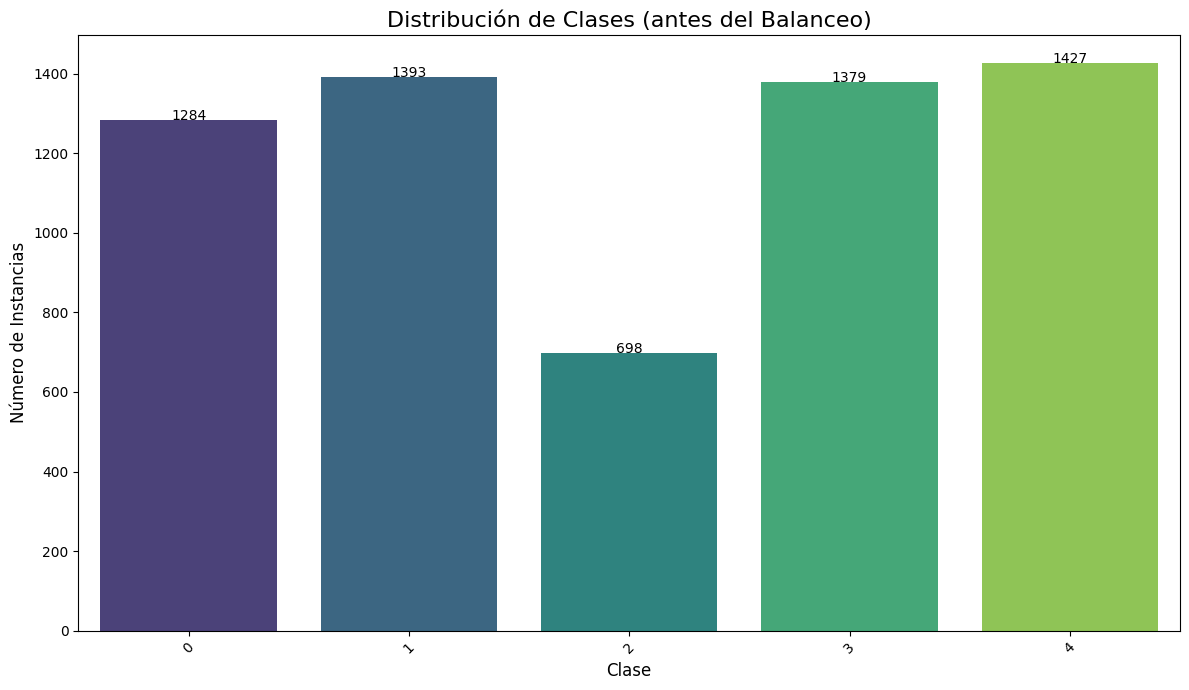

In [ ]:
plot_class_distribution([train_labels_dir], 'Distribución de Clases (antes del Balanceo)', class_names)

#### 3.1 Calcular la distribución inicial y definir el objetivo

In [ ]:
initial_class_counts = Counter()
for label_file in os.listdir(train_labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(train_labels_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(float(line.split()[0]))
                    initial_class_counts[class_id] += 1

other_class_counts = [count for class_id, count in initial_class_counts.items() if class_id != 2]
target_count = int(np.mean(other_class_counts)) if other_class_counts else 0

initial_count_class_2 = initial_class_counts.get(2, 0)

print(f"Distribución inicial: {sorted(initial_class_counts.items())}")
print(f"Instancias iniciales de la clase '2': {initial_count_class_2}")
print(f"Objetivo de instancias (promedio de las otras clases): {target_count}")

Distribución inicial: [(0, 1284), (1, 1393), (2, 698), (3, 1379), (4, 1427)]
Instancias iniciales de la clase '2': 698
Objetivo de instancias (promedio de las otras clases): 1370


In [ ]:
aug_images_dir = os.path.join(os.path.dirname(train_images_dir), 'augmented_images')
aug_labels_dir = os.path.join(os.path.dirname(train_labels_dir), 'augmented_labels')

if os.path.exists(aug_images_dir):
    shutil.rmtree(aug_images_dir)
if os.path.exists(aug_labels_dir):
    shutil.rmtree(aug_labels_dir)
os.makedirs(aug_images_dir, exist_ok=True)
os.makedirs(aug_labels_dir, exist_ok=True)

print(f"\nDirectorios de aumentación limpios en: {aug_images_dir}")


Directorios de aumentación limpios en: dataset\train\augmented_images


In [ ]:
class_2_images = []
for label_file in os.listdir(train_labels_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(train_labels_dir, label_file), 'r') as f:
            for line in f:
                if line.strip() and line.startswith('2 '):
                    class_2_images.append(label_file.replace('.txt', '.jpg'))
                    break

print(f"Se encontraron {len(class_2_images)} imágenes con la clase '2'.")

Se encontraron 698 imágenes con la clase '2'.


In [ ]:
if initial_count_class_2 > 0 and initial_count_class_2 < target_count:
    num_augmentations = math.ceil((target_count / initial_count_class_2) - 1)
    num_augmentations = max(1, num_augmentations)
else:
    num_augmentations = 0

print(f"Se generarán {num_augmentations} aumentos por cada imagen de la clase '2'.")

Se generarán 1 aumentos por cada imagen de la clase '2'.


#### 3.2. Definir la pipeline de aumentación

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=25, p=0.6, border_mode=cv2.BORDER_CONSTANT),
    A.Blur(blur_limit=3, p=0.2),
    A.GaussNoise(p=0.2)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

#### 3.3. Función para generar y guardar imágenes aumentadas

In [ ]:
def augment_and_save(image_path, label_path, output_img_dir, output_lbl_dir, transform, num_augmentations):
    """
    Aplica transformaciones a una imagen y su etiqueta, y guarda los resultados.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    bboxes = []
    class_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x, y, w, h = map(float, line.split())
            bboxes.append([x, y, w, h])
            class_labels.append(int(class_id))

    for i in range(num_augmentations):
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']

        base_name = os.path.splitext(os.path.basename(image_path))[0]
        new_img_name = f"{base_name}_aug_{i}.jpg"
        new_lbl_name = f"{base_name}_aug_{i}.txt"

        aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(output_img_dir, new_img_name), aug_image_bgr)

        with open(os.path.join(output_lbl_dir, new_lbl_name), 'w') as f:
            for bbox, class_id in zip(aug_bboxes, augmented['class_labels']):
                x, y, w, h = bbox
                f.write(f"{class_id} {x} {y} {w} {h}\n")

#### 3.4. Aplicar aumentación

In [ ]:
if num_augmentations > 0:
    for image_name in class_2_images:
        img_path = os.path.join(train_images_dir, image_name)
        lbl_path = os.path.join(train_labels_dir, image_name.replace('.jpg', '.txt'))

        if os.path.exists(img_path):
            augment_and_save(img_path, lbl_path, aug_images_dir, aug_labels_dir, transform, num_augmentations)

    print("\n¡Proceso de aumentación de datos para la clase '2' completado!")
else:
    print("\nNo fue necesario realizar aumentación de datos para la clase '2'.")


¡Proceso de aumentación de datos para la clase '2' completado!


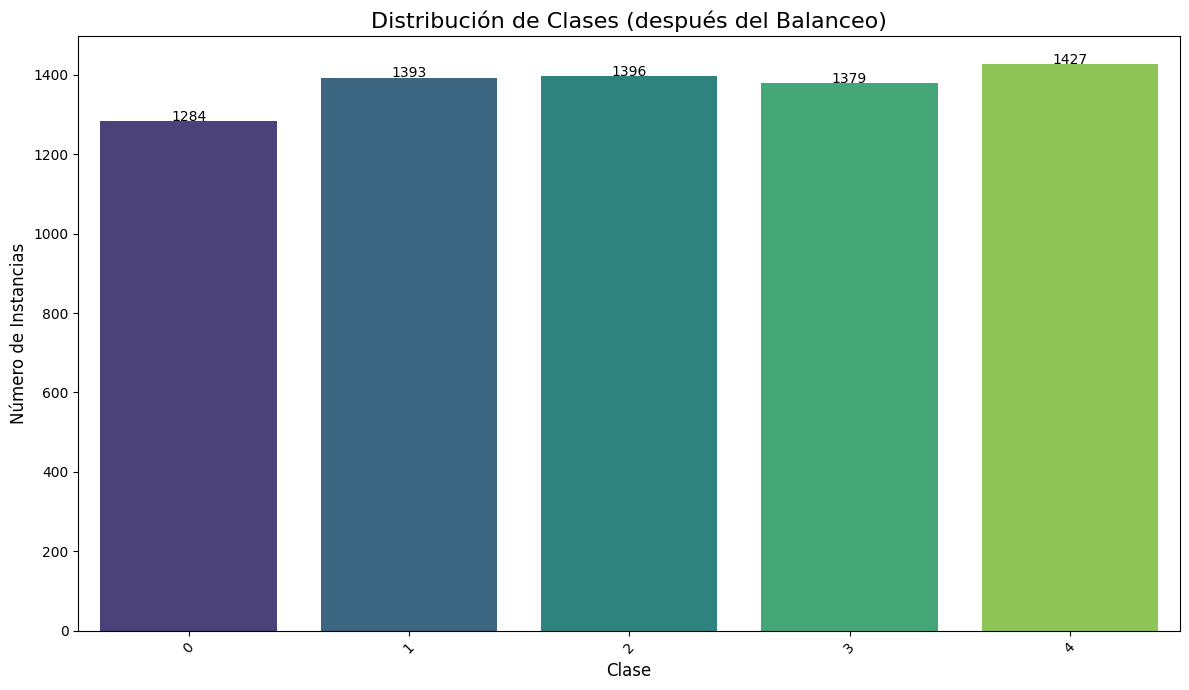

In [ ]:
plot_class_distribution([train_labels_dir, aug_labels_dir], 'Distribución de Clases (después del Balanceo)', class_names)

## Segunda entrega: baseline y conclusiones preliminares

### 1.1 Implementacion de Yolo


Se optó por el modelo YOLO debido a que, al ser un detector de una sola etapa (one-stage detector), presenta un rendimiento superior para la detección de objetos pequeños en contraste con otras arquitecturas.

El objetivo inicial del equipo era implementar y realizar una comparativa de desempeño entre tres modelos: YOLO, Faster R-CNN y CornerNet. Debido a limitaciones de tiempo, esta meta no pudo ser completada. No obstante, las diferentes implementaciones y los resultados parciales obtenidos se encuentran disponibles en las distintas ramas del repositorio. De los modelos evaluados, YOLO fue el que demostró un rendimiento superior.

In [ ]:
!pip -q install -U ultralytics
from ultralytics import YOLO
import torch, subprocess, sys

In [ ]:
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(subprocess.run(["nvidia-smi"], text=True, capture_output=True).stdout[:4000])

CUDA disponible: True
Mon Oct  6 20:06:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.29                 Driver Version: 581.29         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   32C    P8             17W /  170W |     774MiB /  12288MiB |     18%      Default |
|                                         |                        |                  N/A |
+-------------------------

In [ ]:
model = YOLO("yolo11s.pt")

results = model.train(
    data=f"{path}/data.yaml",
    epochs=10,
    imgsz=415,
    batch=-1,
    device=0,
    workers=2,
    patience=5,
    project="runs", name="xray_y11_gpu"
)

Ultralytics 8.3.205  Python-3.12.11 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=415, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=xray_y11_gpu, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, p

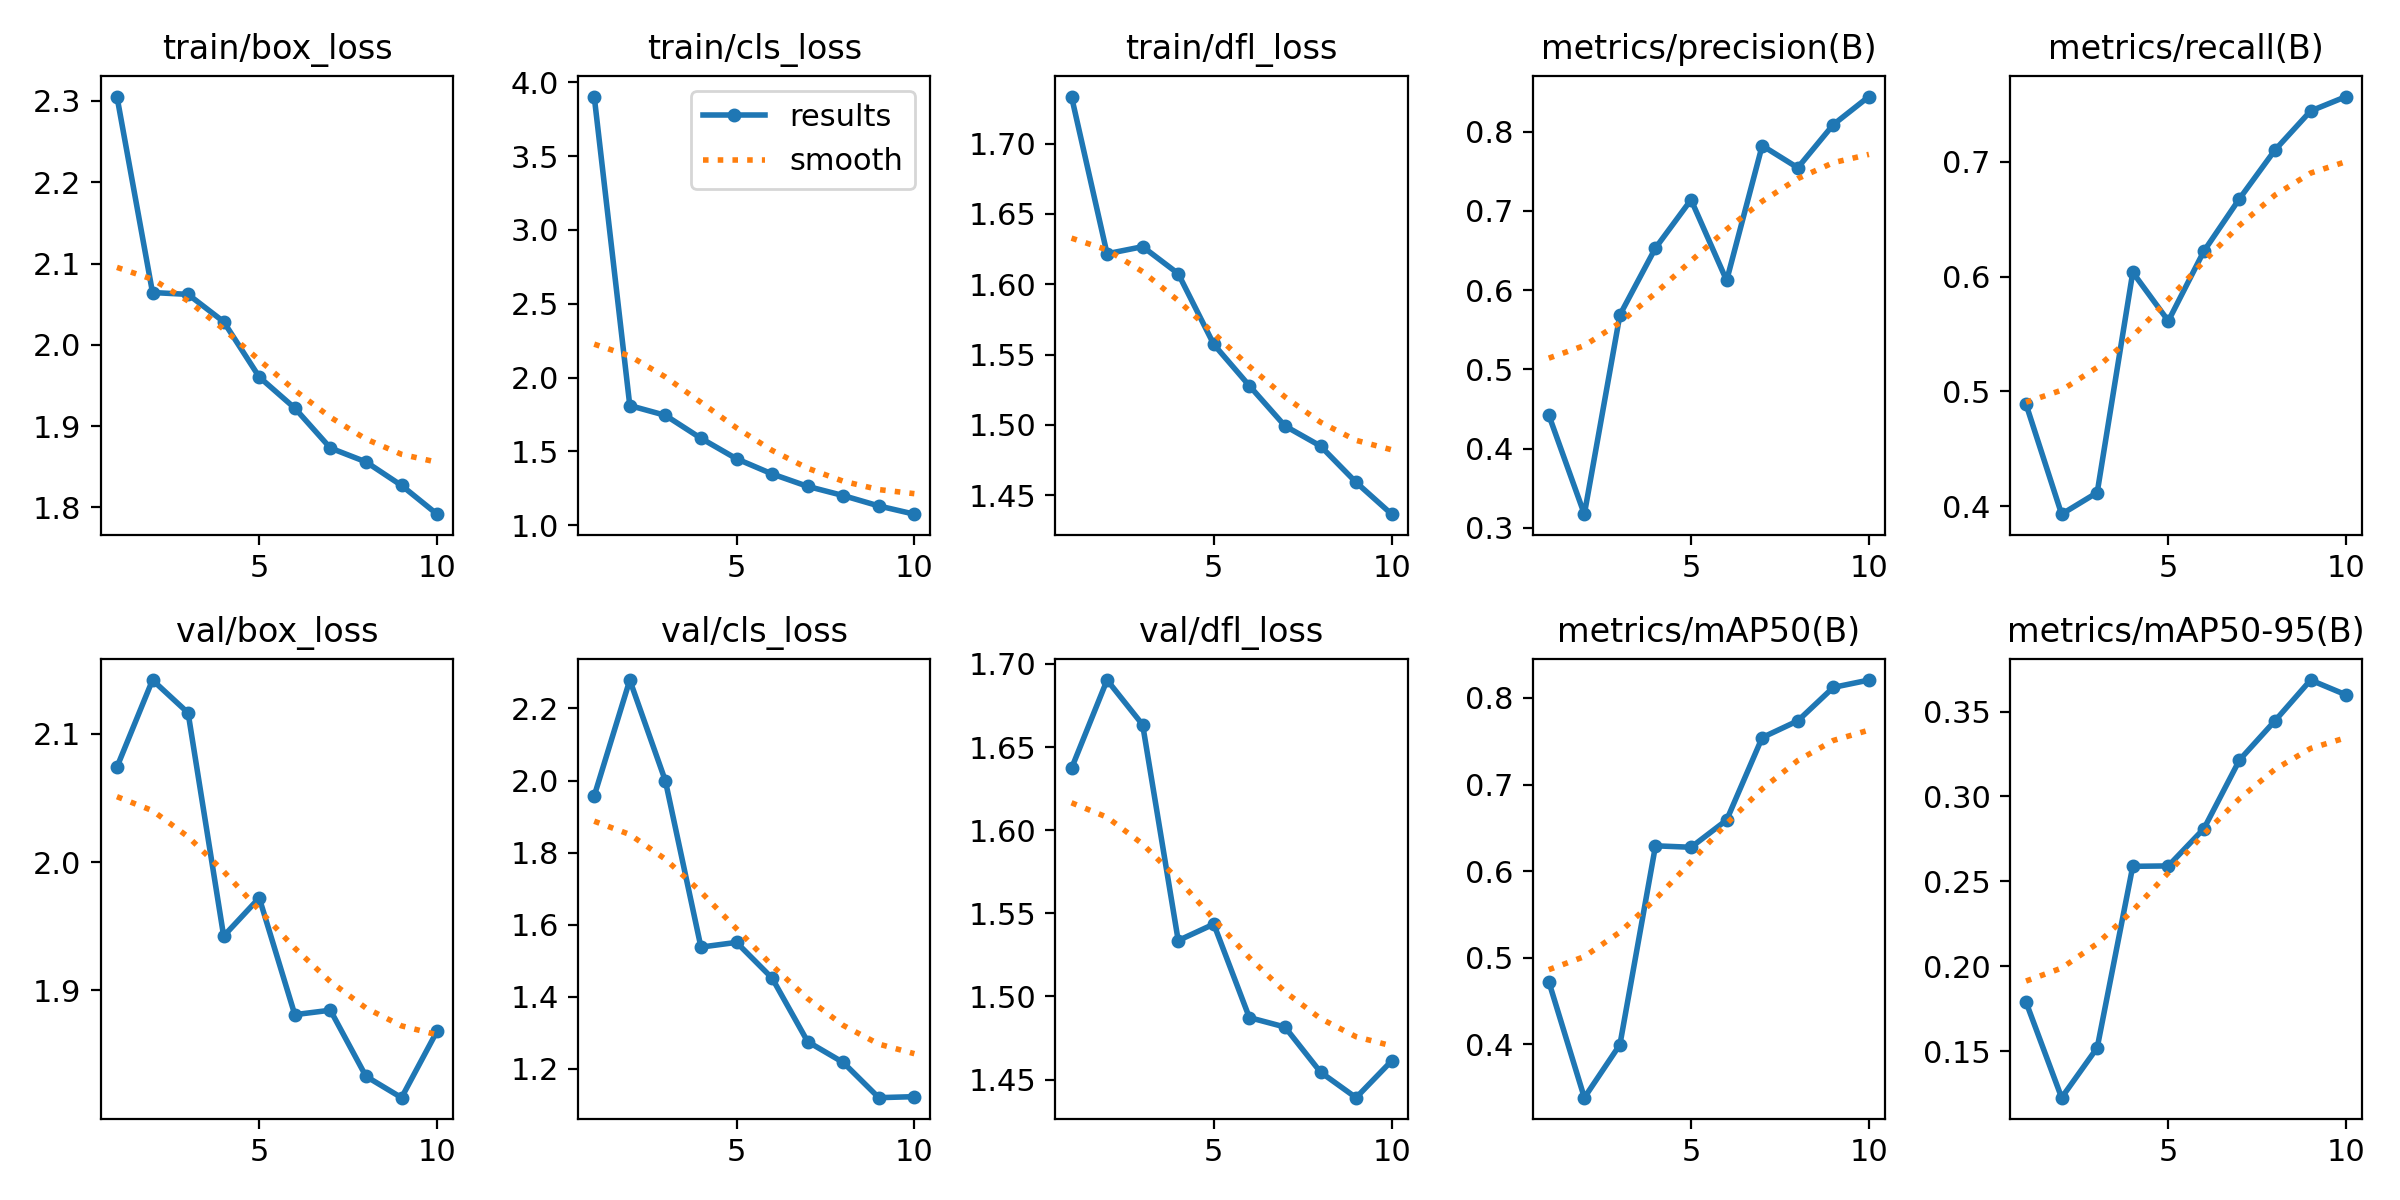

In [ ]:
from IPython.display import Image
Image(filename="runs/xray_y11_gpu/results.png")

Se puede observar que con un modlo simplre (sin realizar una busqueda de los mejores hiperparametros) y pocas epocas se logran obtener buenos resultados obteniendo que la precision medai promedio de 50 llega a valorres cercanos 0.8 mientras el caso de 50-95 llega muy proximo a 0.35. Esto muestra que en el caso de querer optimizar este modelo, es posible llegar a resultados inclusive mejores.

In [ ]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.205  Python-3.12.11 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 6.95.0 ms, read: 0.50.2 MB/s, size: 18.7 KB)
val: Scanning G:\Mi unidad\Especilizacion IA\Bimestre 4\VPC II\Trabajo-Final-VPC2\dataset\valid\labels.cache... 1766 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1766/1766  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 111/111 10.6it/s 10.5s0.2s
                   all       1766       1766      0.808      0.742       0.81      0.369
                     0        391        391      0.946      0.964      0.976      0.517
                     1        389        389      0.776      0.846      0.875      0.378
                     2        225        225      0.702      0.335      0.527       0.19
                     3        366        366      0.766      0.694 

### 2.2 Validacion de modelo Yolo

In [ ]:
best = "runs/xray_y11_gpu/weights/best.pt"
trained_model = YOLO(best)

# Carpeta completa
trained_model.predict(
    source="dataset/test/images",  # o una carpeta de test
    conf=0.25,    # umbral de confianza
    iou=0.7,      # supresión de no-máximos
    save=True     # guarda imágenes con cajas dibujadas
)


image 1/883 g:\Mi unidad\Especilizacion IA\Bimestre 4\VPC II\Trabajo-Final-VPC2\dataset\test\images\009008_jpg.rf.8f9d287571d5d48f46a87116a4a82d56.jpg: 416x416 (no detections), 13.3ms
image 2/883 g:\Mi unidad\Especilizacion IA\Bimestre 4\VPC II\Trabajo-Final-VPC2\dataset\test\images\009024_jpg.rf.6de3f50660b30e85323eb009190d7747.jpg: 416x416 2 2s, 9.0ms
image 3/883 g:\Mi unidad\Especilizacion IA\Bimestre 4\VPC II\Trabajo-Final-VPC2\dataset\test\images\009030_jpg.rf.c072eddbe5c4df12ba092a3fea353d7c.jpg: 416x416 2 2s, 8.0ms
image 4/883 g:\Mi unidad\Especilizacion IA\Bimestre 4\VPC II\Trabajo-Final-VPC2\dataset\test\images\009045_jpg.rf.73baf175ea33c52e85c53979fcc1cde0.jpg: 416x416 1 2, 7.3ms
image 5/883 g:\Mi unidad\Especilizacion IA\Bimestre 4\VPC II\Trabajo-Final-VPC2\dataset\test\images\009072_jpg.rf.ee449c968c7fbd052f338148998aff10.jpg: 416x416 2 2s, 12.6ms
image 6/883 g:\Mi unidad\Especilizacion IA\Bimestre 4\VPC II\Trabajo-Final-VPC2\dataset\test\images\009120_jpg.rf.b9474a4f0775a

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}
 obb: None
 orig_img: array([[[254, 254, 254],
         [254, 254, 254],
         [254, 254, 254],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [254, 254, 254]],
 
        [[254, 254, 254],
         [254, 254, 254],
         [254, 254, 254],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [254, 254, 254]],
 
        [[254, 254, 254],
         [254, 254, 254],
         [254, 254, 254],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [254, 254, 254]],
 
        ...,
 
        [[254, 254, 254],
         [254, 254, 254],
         [254, 254, 254],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [254, 254, 254]],
 
        [[254, 254, 254],
         [254, 254, 254],
         [254, 254, 254],
     

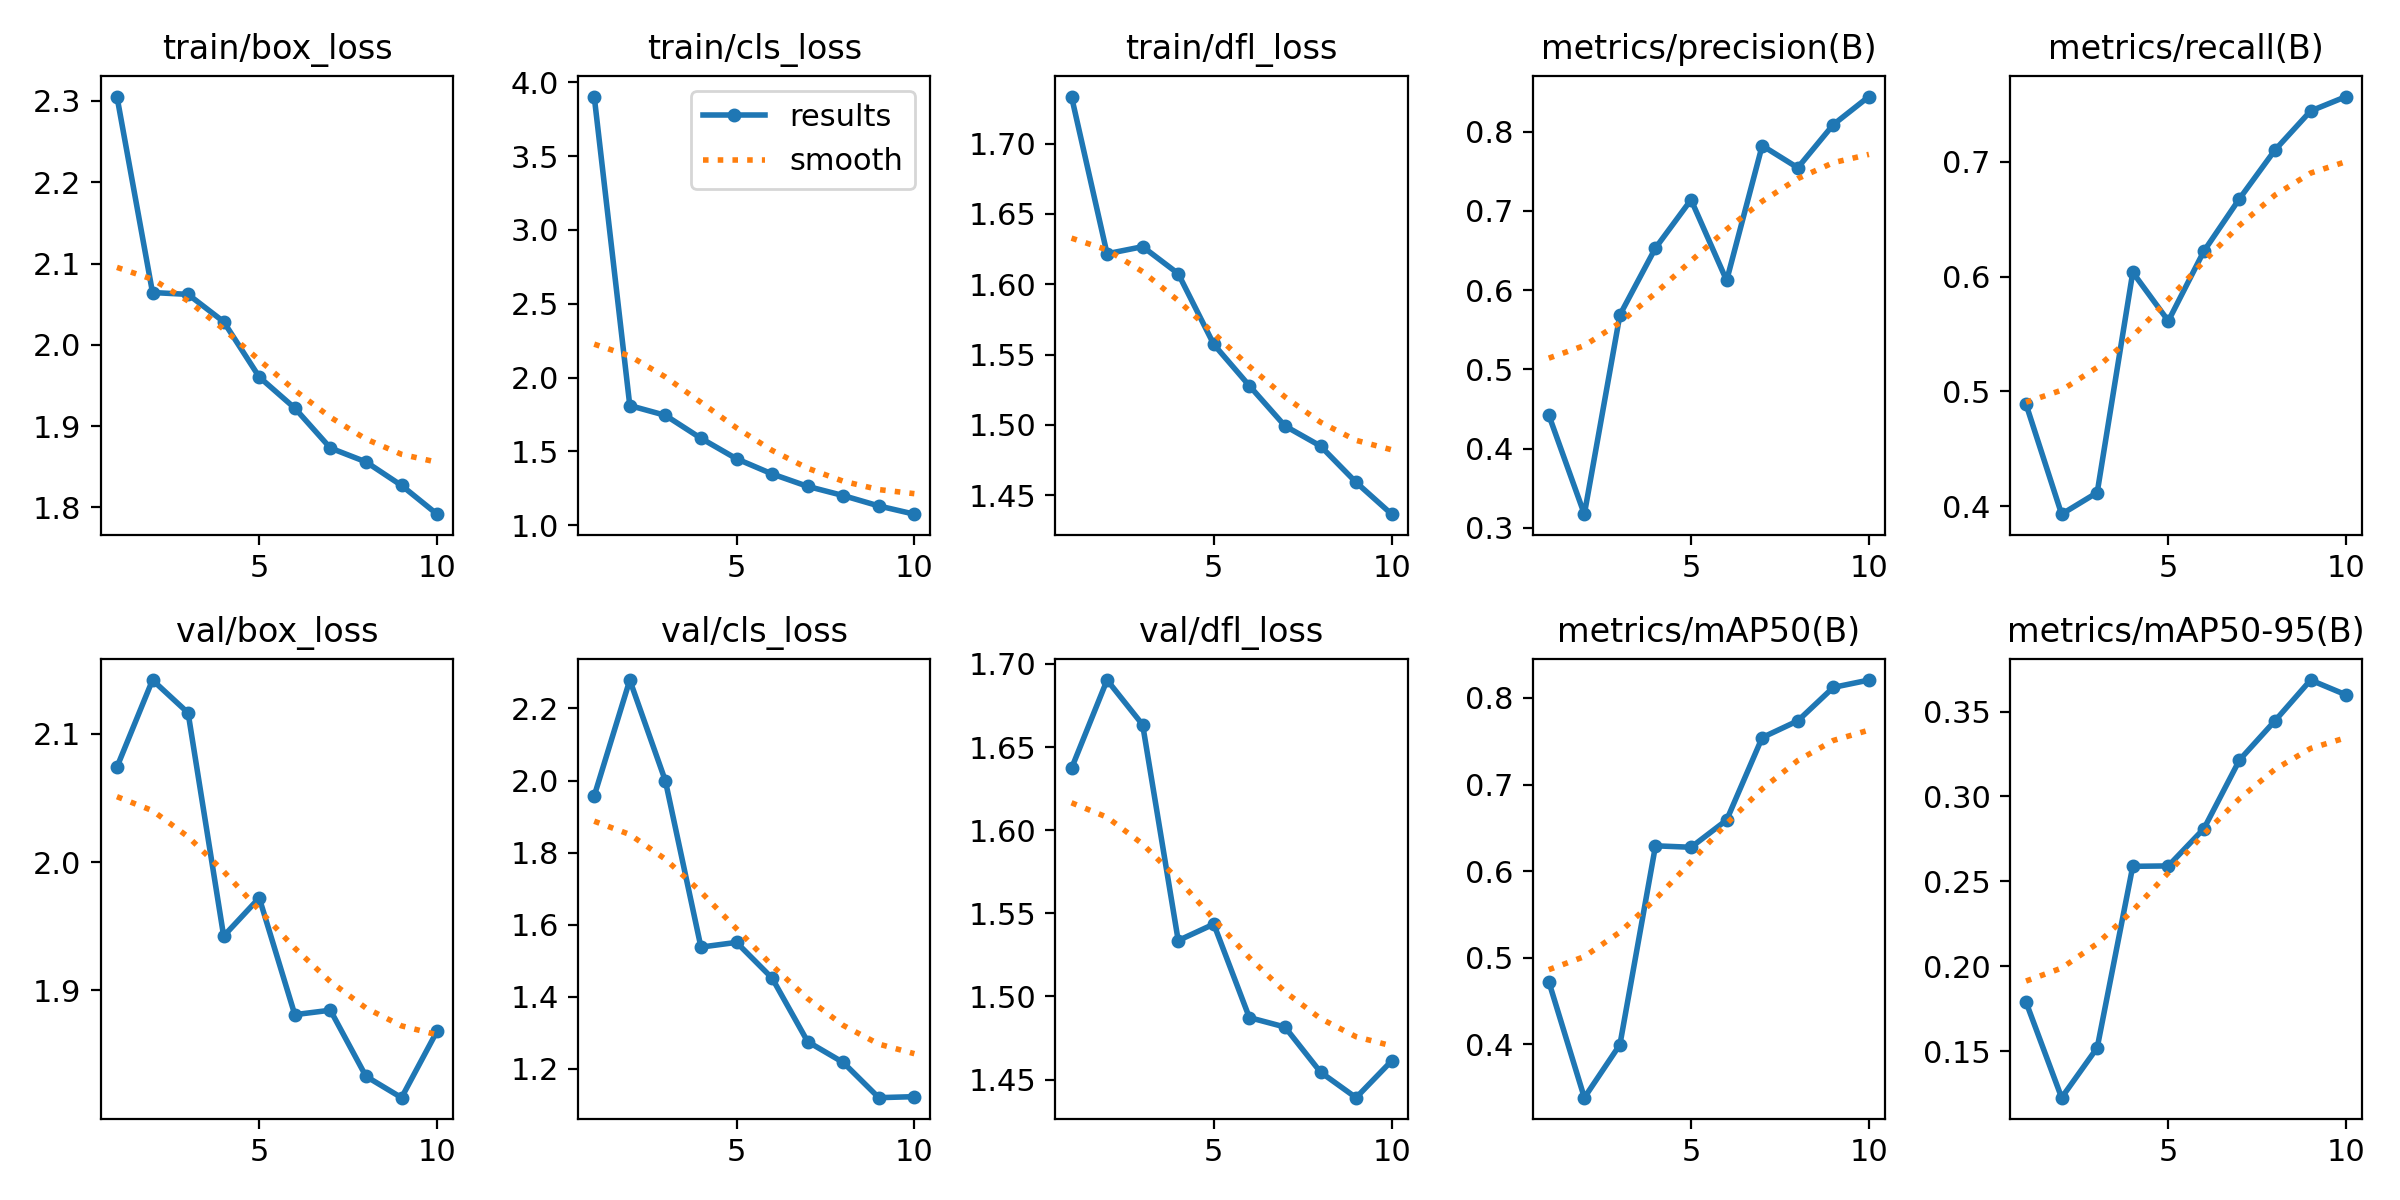

In [ ]:
from IPython.display import Image
Image(filename="runs/xray_y11_gpu/results.png")

Una evaluación preliminar del modelo sobre el conjunto de imágenes de prueba (test) muestra un rendimiento general muy positivo.

### Busqueda de hiperparametros del modelo

Con el modelo base definido, se procedió a optimizar su rendimiento para encontrar la configuración que mejor se adapte al problema. Para este fin, se implementó una búsqueda de hiperparámetros con la librería Optuna.

El objetivo de la optimización fue maximizar la métrica mAP@[.5:.95]. Esta se seleccionó por ser un indicador robusto que evalúa el desempeño del modelo bajo múltiples y exigentes umbrales de localización (IoU de 0.50 a 0.95).

In [ ]:
!pip install optuna
import optuna


  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached sqlalchemy-2.0.43-cp312-cp312-win_amd64.whl.metadata (9.8 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
  Using cached greenlet-3.2.4-cp312-cp312-win_amd64.whl.metadata (4.2 kB)
Using cached sqlalchemy-2.0.43-cp312-cp312-win_amd64.whl (2.1 MB)
Using cached greenlet-3.2.4-cp312-cp312-win_amd64.whl (299 kB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)
Using cached mako-1.3.10-py3-none-any.whl (78 kB)

   ------ --------------------------------- 1/6 [greenlet]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -------------------- ------------------- 3/6 [sqlalchemy]
   -

In [ ]:
def objective(trial):
  try:
    model = YOLO("yolo11s.pt")
    args = {
        "data": f"{path}/data.yaml",
        "epochs": 10,
        "batch": -1,
        "imgsz": 415,
        "optimizer": 'AdamW',
        "verbose": False,
        "patience": 0,
        'lr0': trial.suggest_float('lr0', 1e-5, 1e-1, log=True),
        'lrf': trial.suggest_float('lrf', 0.01, 1.0),
        'momentum': trial.suggest_float('momentum', 0.6, 0.98),
        'weight_decay': trial.suggest_float('weight_decay', 0.0, 0.001),
        'warmup_epochs': trial.suggest_float('warmup_epochs', 0.0, 5.0),
        'warmup_momentum': trial.suggest_float('warmup_momentum', 0.0, 0.95),
        'box': trial.suggest_float('box', 1.0, 15.0),
        'cls': trial.suggest_float('cls', 0.1, 2.0),
    }

    results = model.train(**args)

    return results.metrics['metrics/mAP50-95(B)']

  except Exception as e:
        print(f"Un 'trial' falló con el error: {e}")
        return 0.0


In [ ]:
study = optuna.create_study(direction='maximize')


[I 2025-10-06 20:33:35,089] A new study created in memory with name: no-name-b3996439-7b6e-4511-893e-ef6dbc26076a


In [ ]:
study.optimize(objective, n_trials=75)

Ultralytics 8.3.205  Python-3.12.11 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=14.253438961402919, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.6145931773562434, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=415, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00012755565322607987, lrf=0.5907279363462773, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.871215011533488, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=

[I 2025-10-06 20:43:27,935] Trial 0 finished with value: 0.0 and parameters: {'lr0': 0.00012755565322607987, 'lrf': 0.5907279363462773, 'momentum': 0.871215011533488, 'weight_decay': 0.0004287187964203426, 'warmup_epochs': 3.2965042486226865, 'warmup_momentum': 0.08135249499650839, 'box': 14.253438961402919, 'cls': 0.6145931773562434}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 20:53:25,716] Trial 1 finished with value: 0.0 and parameters: {'lr0': 0.00012369336849367977, 'lrf': 0.7197664223401687, 'momentum': 0.6781731119137056, 'weight_decay': 0.0003771353473727687, 'warmup_epochs': 4.507796493029145, 'warmup_momentum': 0.8283247706797656, 'box': 4.859427670576978, 'cls': 0.4102238686180565}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 21:03:22,058] Trial 2 finished with value: 0.0 and parameters: {'lr0': 0.0034210571256541806, 'lrf': 0.9452054979014196, 'momentum': 0.7550890705305204, 'weight_decay': 0.000432777447015135, 'warmup_epochs': 2.811455755755934, 'warmup_momentum': 0.7594410563090841, 'box': 3.577779917892021, 'cls': 1.5037908406851141}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 21:12:57,413] Trial 3 finished with value: 0.0 and parameters: {'lr0': 9.723248548081234e-05, 'lrf': 0.21866145181121815, 'momentum': 0.7493655666995513, 'weight_decay': 0.00032136318461897106, 'warmup_epochs': 2.540130545652351, 'warmup_momentum': 0.17863229765353747, 'box': 13.667349765685902, 'cls': 1.4142098157986793}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 21:22:57,207] Trial 4 finished with value: 0.0 and parameters: {'lr0': 1.1140304511515247e-05, 'lrf': 0.25463216404079014, 'momentum': 0.6900978084626026, 'weight_decay': 0.0007633103952035536, 'warmup_epochs': 1.3533178326907809, 'warmup_momentum': 0.8971330576448197, 'box': 1.2660442021106226, 'cls': 0.5013011805164658}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 21:32:47,849] Trial 5 finished with value: 0.0 and parameters: {'lr0': 0.0016817013815928216, 'lrf': 0.028820432827961755, 'momentum': 0.9454429404593577, 'weight_decay': 0.0008856103415742405, 'warmup_epochs': 4.497447700668172, 'warmup_momentum': 0.43686936451533775, 'box': 7.402513707425794, 'cls': 1.1455512093659186}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 21:42:58,743] Trial 6 finished with value: 0.0 and parameters: {'lr0': 0.0005774091195395606, 'lrf': 0.3099427815092363, 'momentum': 0.6403328684014387, 'weight_decay': 0.0002498719040939772, 'warmup_epochs': 3.696599304168908, 'warmup_momentum': 0.10079348225532545, 'box': 5.697864667851181, 'cls': 1.0081198656079233}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 21:52:48,657] Trial 7 finished with value: 0.0 and parameters: {'lr0': 1.847134208534954e-05, 'lrf': 0.4053715515244416, 'momentum': 0.7618988437117657, 'weight_decay': 0.0006036892330465518, 'warmup_epochs': 3.732684208940798, 'warmup_momentum': 0.5701672250392052, 'box': 5.469984330731253, 'cls': 1.8827157359134696}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 22:02:43,440] Trial 8 finished with value: 0.0 and parameters: {'lr0': 0.00012509905328873984, 'lrf': 0.4232412616608396, 'momentum': 0.8884965279197151, 'weight_decay': 0.0001727566772858784, 'warmup_epochs': 3.8375614785342855, 'warmup_momentum': 0.47065531174038644, 'box': 8.030973326874005, 'cls': 1.2782948400177483}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 22:12:30,295] Trial 9 finished with value: 0.0 and parameters: {'lr0': 0.015025345569489016, 'lrf': 0.5012093590861204, 'momentum': 0.9317972771015761, 'weight_decay': 0.0008575293525937967, 'warmup_epochs': 0.12604603217329924, 'warmup_momentum': 0.14510173010239977, 'box': 10.867214618131301, 'cls': 1.263830012255332}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 22:21:49,160] Trial 10 finished with value: 0.0 and parameters: {'lr0': 0.08756410995439495, 'lrf': 0.6808423084822132, 'momentum': 0.8475362222754408, 'weight_decay': 7.0521745102685536e-06, 'warmup_epochs': 1.5313076789899651, 'warmup_momentum': 0.27748757402622815, 'box': 14.429289637635119, 'cls': 0.21771592278775098}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 22:31:36,423] Trial 11 finished with value: 0.0 and parameters: {'lr0': 0.00017482058647631782, 'lrf': 0.7230181533345951, 'momentum': 0.8342507527465306, 'weight_decay': 0.0005794250244793263, 'warmup_epochs': 4.965087882498944, 'warmup_momentum': 0.6724453483353365, 'box': 10.499840748540963, 'cls': 0.6503942258353875}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 22:41:19,308] Trial 12 finished with value: 0.0 and parameters: {'lr0': 4.6302812662859164e-05, 'lrf': 0.7146759905501197, 'momentum': 0.6188395070512868, 'weight_decay': 0.0004367834291935007, 'warmup_epochs': 2.9593078872972773, 'warmup_momentum': 0.9395440985012267, 'box': 11.37531033686983, 'cls': 0.69786958332248}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 22:51:03,421] Trial 13 finished with value: 0.0 and parameters: {'lr0': 0.00035812035809915934, 'lrf': 0.9705727327929952, 'momentum': 0.6958272339878839, 'weight_decay': 0.0006663109568097257, 'warmup_epochs': 4.250853758824977, 'warmup_momentum': 0.019897452256820602, 'box': 2.8752161577324156, 'cls': 0.15064085371931096}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 23:00:48,879] Trial 14 finished with value: 0.0 and parameters: {'lr0': 5.1964883459547766e-05, 'lrf': 0.6162775816239623, 'momentum': 0.8228834693705431, 'weight_decay': 0.00039608568391564635, 'warmup_epochs': 1.9250634628710144, 'warmup_momentum': 0.3213425243703193, 'box': 8.142078438718999, 'cls': 0.4454510306318298}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 23:10:34,889] Trial 15 finished with value: 0.0 and parameters: {'lr0': 0.0016783893482403222, 'lrf': 0.8594741388548068, 'momentum': 0.8983551147226708, 'weight_decay': 0.00014860502572533436, 'warmup_epochs': 3.2765408366286395, 'warmup_momentum': 0.7531044183241198, 'box': 12.59485572839799, 'cls': 0.8689127172758584}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 23:20:26,871] Trial 16 finished with value: 0.0 and parameters: {'lr0': 0.0003605880828433371, 'lrf': 0.8195490031566441, 'momentum': 0.6894772287743032, 'weight_decay': 0.0005224807954544831, 'warmup_epochs': 4.920240453861906, 'warmup_momentum': 0.5925802115433542, 'box': 5.769900413147038, 'cls': 0.4552647562890237}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 23:30:14,829] Trial 17 finished with value: 0.0 and parameters: {'lr0': 3.4426848910809126e-05, 'lrf': 0.5894607024401195, 'momentum': 0.8037764432442398, 'weight_decay': 0.0003014103661781374, 'warmup_epochs': 4.095542627345088, 'warmup_momentum': 0.3357276733902671, 'box': 9.838272629673526, 'cls': 0.30866653777199377}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 23:39:57,856] Trial 18 finished with value: 0.0 and parameters: {'lr0': 0.008528472169599231, 'lrf': 0.8195159775718368, 'momentum': 0.8704921367330699, 'weight_decay': 0.0009878015916551196, 'warmup_epochs': 3.250125592136327, 'warmup_momentum': 0.8205531495276243, 'box': 3.6385176283111518, 'cls': 0.770079806801351}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 23:49:45,882] Trial 19 finished with value: 0.0 and parameters: {'lr0': 0.00021087022449391168, 'lrf': 0.5718307476715785, 'momentum': 0.9777741770908202, 'weight_decay': 2.809239229845345e-06, 'warmup_epochs': 2.1018739086816245, 'warmup_momentum': 0.5695498327607464, 'box': 14.959148214299313, 'cls': 0.884740949678678}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-06 23:59:33,308] Trial 20 finished with value: 0.0 and parameters: {'lr0': 0.0008055779118647969, 'lrf': 0.4746187730962694, 'momentum': 0.7237461923262936, 'weight_decay': 0.0006936186808596818, 'warmup_epochs': 0.5754219280981789, 'warmup_momentum': 0.23199831013317185, 'box': 9.259465842379118, 'cls': 0.5327061590471075}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 00:09:35,034] Trial 21 finished with value: 0.0 and parameters: {'lr0': 0.0035213049835549877, 'lrf': 0.9672177581025709, 'momentum': 0.7867771381286263, 'weight_decay': 0.00045208551833102835, 'warmup_epochs': 2.6807034562508716, 'warmup_momentum': 0.7111180562828794, 'box': 4.328018717695712, 'cls': 1.6342404638311065}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 00:19:19,179] Trial 22 finished with value: 0.0 and parameters: {'lr0': 0.00876319732739368, 'lrf': 0.9097181105517986, 'momentum': 0.6547535837654777, 'weight_decay': 0.00037368020425910934, 'warmup_epochs': 3.2943587585715965, 'warmup_momentum': 0.8418123399144284, 'box': 1.7734376146617503, 'cls': 1.6240771556704567}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 00:29:02,545] Trial 23 finished with value: 0.0 and parameters: {'lr0': 0.044196693636759064, 'lrf': 0.7806064739795417, 'momentum': 0.7385099136390746, 'weight_decay': 0.0005089373922654279, 'warmup_epochs': 2.193835827407685, 'warmup_momentum': 0.7826613856848083, 'box': 6.829825671660475, 'cls': 1.9020994372032238}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 00:38:59,983] Trial 24 finished with value: 0.0 and parameters: {'lr0': 0.0031001443357854003, 'lrf': 0.6633703062658206, 'momentum': 0.7783487907870298, 'weight_decay': 0.00016424837488936275, 'warmup_epochs': 2.89336068215065, 'warmup_momentum': 0.6864878228953333, 'box': 2.894521859285656, 'cls': 1.660076348886592}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 00:48:50,036] Trial 25 finished with value: 0.0 and parameters: {'lr0': 8.169431936825441e-05, 'lrf': 0.909871765285007, 'momentum': 0.6018479161188547, 'weight_decay': 0.0002594946711262777, 'warmup_epochs': 4.3976418639982935, 'warmup_momentum': 0.6195154876101818, 'box': 4.402430801245767, 'cls': 0.31114576553126694}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 00:58:30,333] Trial 26 finished with value: 0.0 and parameters: {'lr0': 0.0003529032611548842, 'lrf': 0.7535996428848771, 'momentum': 0.714680370764894, 'weight_decay': 0.0003660586301165099, 'warmup_epochs': 3.4932116534662603, 'warmup_momentum': 0.8700225597925295, 'box': 2.5947597361897783, 'cls': 1.4340795585428507}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 01:08:19,007] Trial 27 finished with value: 0.0 and parameters: {'lr0': 0.0013831383023480675, 'lrf': 0.9948180577235458, 'momentum': 0.6629970184607553, 'weight_decay': 0.0005610394041978554, 'warmup_epochs': 4.656553503259652, 'warmup_momentum': 0.3718063982336136, 'box': 4.8556144484319255, 'cls': 1.0130520755540993}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 01:18:17,090] Trial 28 finished with value: 0.0 and parameters: {'lr0': 0.0041180087462655115, 'lrf': 0.5852113795041696, 'momentum': 0.8065360912497024, 'weight_decay': 0.00047664829748243927, 'warmup_epochs': 3.9869345650894403, 'warmup_momentum': 0.524656472625485, 'box': 6.600465472788507, 'cls': 0.6179019662562272}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 01:27:59,210] Trial 29 finished with value: 0.0 and parameters: {'lr0': 8.493682856448665e-05, 'lrf': 0.8680829950920865, 'momentum': 0.7567949196068382, 'weight_decay': 0.00031702857114476767, 'warmup_epochs': 2.4078279093278945, 'warmup_momentum': 0.029130620887670447, 'box': 13.150404257760718, 'cls': 1.4373940054611343}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 01:37:42,175] Trial 30 finished with value: 0.0 and parameters: {'lr0': 2.4374932443335767e-05, 'lrf': 0.537002252372752, 'momentum': 0.8502711832391747, 'weight_decay': 9.324627498216286e-05, 'warmup_epochs': 1.4750607048488464, 'warmup_momentum': 0.4170081395577143, 'box': 12.141424590990955, 'cls': 0.3382381261411107}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 01:47:28,960] Trial 31 finished with value: 0.0 and parameters: {'lr0': 8.474115371949378e-05, 'lrf': 0.10578913863676431, 'momentum': 0.7491060377644512, 'weight_decay': 0.00032327923257321984, 'warmup_epochs': 2.5168613270408446, 'warmup_momentum': 0.1693101754126831, 'box': 13.692596325136495, 'cls': 1.4919508389037994}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 01:57:19,201] Trial 32 finished with value: 0.0 and parameters: {'lr0': 1.2037763075546195e-05, 'lrf': 0.34088740873551016, 'momentum': 0.6900374500792346, 'weight_decay': 0.0002519972031462715, 'warmup_epochs': 2.793768007210217, 'warmup_momentum': 0.08875201797433746, 'box': 13.727562673406064, 'cls': 1.1527673612342753}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 02:07:08,154] Trial 33 finished with value: 0.0 and parameters: {'lr0': 0.00021192120054009376, 'lrf': 0.21166042150320474, 'momentum': 0.7210260005460437, 'weight_decay': 0.0003983985799526497, 'warmup_epochs': 1.9408024651165097, 'warmup_momentum': 0.2035772382461909, 'box': 8.956001955547755, 'cls': 1.3122650062347547}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 02:16:53,041] Trial 34 finished with value: 0.0 and parameters: {'lr0': 0.0011131734788052314, 'lrf': 0.15790640329269257, 'momentum': 0.7722151121236803, 'weight_decay': 0.00044602479794261747, 'warmup_epochs': 3.0431622032825154, 'warmup_momentum': 0.08350320262459139, 'box': 1.3765700269514163, 'cls': 1.747629900657834}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 02:26:40,889] Trial 35 finished with value: 0.0 and parameters: {'lr0': 0.0005921011147723383, 'lrf': 0.35216555158140705, 'momentum': 0.6691641690566615, 'weight_decay': 0.00023062264822570387, 'warmup_epochs': 3.5691109118460886, 'warmup_momentum': 0.9346235866345297, 'box': 12.12988606647526, 'cls': 1.9975971689562144}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 02:36:33,721] Trial 36 finished with value: 0.0 and parameters: {'lr0': 1.038273300427512e-05, 'lrf': 0.02019203319856311, 'momentum': 0.9265661319592177, 'weight_decay': 0.0006349351403855097, 'warmup_epochs': 2.4771059959651427, 'warmup_momentum': 0.13469387818876477, 'box': 5.654861863239651, 'cls': 1.1074667649857068}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 02:46:32,880] Trial 37 finished with value: 0.0 and parameters: {'lr0': 0.00014449975798628477, 'lrf': 0.4246058483594931, 'momentum': 0.7376773057596653, 'weight_decay': 0.0007526312109019122, 'warmup_epochs': 1.1375754429947964, 'warmup_momentum': 0.24863621622646143, 'box': 14.952764911520653, 'cls': 0.8892342539686932}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 02:56:31,009] Trial 38 finished with value: 0.0 and parameters: {'lr0': 2.9429998369104682e-05, 'lrf': 0.2891204690947541, 'momentum': 0.8035950926369331, 'weight_decay': 0.0005350373899445669, 'warmup_epochs': 3.830294283573778, 'warmup_momentum': 0.7622946222180396, 'box': 3.5706286371613762, 'cls': 0.10023500852996564}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 03:06:26,920] Trial 39 finished with value: 0.0 and parameters: {'lr0': 5.865220220239147e-05, 'lrf': 0.46846531715559275, 'momentum': 0.6320714430737819, 'weight_decay': 0.00033844325175762556, 'warmup_epochs': 1.1920572164469552, 'warmup_momentum': 0.508802143476821, 'box': 14.057153112687505, 'cls': 1.2231942273617626}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 03:16:16,310] Trial 40 finished with value: 0.0 and parameters: {'lr0': 1.778276466855958e-05, 'lrf': 0.6980955393741499, 'momentum': 0.906278949908061, 'weight_decay': 9.502547930142141e-05, 'warmup_epochs': 1.7824251026255893, 'warmup_momentum': 0.052712214643006364, 'box': 6.550668028068342, 'cls': 1.5247501298691728}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 03:26:15,215] Trial 41 finished with value: 0.0 and parameters: {'lr0': 0.002277225679002672, 'lrf': 0.2665682377459982, 'momentum': 0.7035421381892671, 'weight_decay': 0.0008658273310490396, 'warmup_epochs': 0.5511010186930692, 'warmup_momentum': 0.8875492327278508, 'box': 2.074911252308203, 'cls': 0.5487360536595485}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 03:36:14,256] Trial 42 finished with value: 0.0 and parameters: {'lr0': 0.00029881797511580385, 'lrf': 0.07110626030180398, 'momentum': 0.685350471788969, 'weight_decay': 0.0007932590456858409, 'warmup_epochs': 2.251216775836417, 'warmup_momentum': 0.9003694799818425, 'box': 3.6898562934701986, 'cls': 1.3491565616086565}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 03:46:13,187] Trial 43 finished with value: 0.0 and parameters: {'lr0': 0.0001107260301208729, 'lrf': 0.2249532106629872, 'momentum': 0.644649283245588, 'weight_decay': 0.0004109681597763333, 'warmup_epochs': 3.103754946802675, 'warmup_momentum': 0.8138546017361034, 'box': 10.953820286683438, 'cls': 0.41338349206894365}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 03:56:07,290] Trial 44 finished with value: 0.0 and parameters: {'lr0': 0.0006971377368103303, 'lrf': 0.6281271881937958, 'momentum': 0.6772415503576732, 'weight_decay': 0.0009367637210402041, 'warmup_epochs': 2.6323744924595047, 'warmup_momentum': 0.9493378101155039, 'box': 1.1143092359512892, 'cls': 0.7922939680427725}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 04:05:55,196] Trial 45 finished with value: 0.0 and parameters: {'lr0': 4.4328751370914495e-05, 'lrf': 0.372659746079702, 'momentum': 0.7620540176483228, 'weight_decay': 0.0004907251298727547, 'warmup_epochs': 4.656328399544274, 'warmup_momentum': 0.7154550667683164, 'box': 2.7343347555043946, 'cls': 0.551082484785816}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 04:15:41,706] Trial 46 finished with value: 0.0 and parameters: {'lr0': 1.7914758299132208e-05, 'lrf': 0.6567277970093721, 'momentum': 0.8292535563746887, 'weight_decay': 0.0005961200179159321, 'warmup_epochs': 0.09402583953549115, 'warmup_momentum': 0.6453521960491047, 'box': 7.801617356465075, 'cls': 0.21080976826881168}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 04:25:21,192] Trial 47 finished with value: 0.0 and parameters: {'lr0': 0.02895612572808989, 'lrf': 0.5349598953568254, 'momentum': 0.8678848019061557, 'weight_decay': 0.00028463081116625083, 'warmup_epochs': 1.580711250265857, 'warmup_momentum': 0.8574509773802605, 'box': 4.98695157997527, 'cls': 0.6981429023668803}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 04:35:35,383] Trial 48 finished with value: 0.0 and parameters: {'lr0': 0.0063063059448467225, 'lrf': 0.17389380384854328, 'momentum': 0.7058335465581671, 'weight_decay': 0.0002288397364731039, 'warmup_epochs': 3.4664214323098355, 'warmup_momentum': 0.7942694603442539, 'box': 2.013497652521834, 'cls': 0.37063282405566034}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 04:45:20,781] Trial 49 finished with value: 0.0 and parameters: {'lr0': 0.0002715886163759795, 'lrf': 0.761392010363127, 'momentum': 0.7353798763830942, 'weight_decay': 0.0007067749352211781, 'warmup_epochs': 0.5321077535180352, 'warmup_momentum': 0.004669774882775382, 'box': 12.969905115997935, 'cls': 0.9567819064731726}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 04:55:11,946] Trial 50 finished with value: 0.0 and parameters: {'lr0': 0.0004944225310347453, 'lrf': 0.12629222038116028, 'momentum': 0.8146533109889981, 'weight_decay': 0.0003520348094241735, 'warmup_epochs': 4.088952881085763, 'warmup_momentum': 0.7529610500313126, 'box': 3.3244967341938185, 'cls': 0.2630780870653043}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 05:05:07,445] Trial 51 finished with value: 0.0 and parameters: {'lr0': 0.0009741349778104618, 'lrf': 0.011166631084040042, 'momentum': 0.9786676534256171, 'weight_decay': 0.0008684629444379844, 'warmup_epochs': 4.351760071223238, 'warmup_momentum': 0.30507086379760806, 'box': 7.485756220815556, 'cls': 1.2132780831664394}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 05:14:50,876] Trial 52 finished with value: 0.0 and parameters: {'lr0': 0.001652400012474879, 'lrf': 0.4239609413100845, 'momentum': 0.9581983021688038, 'weight_decay': 0.0009172273150301899, 'warmup_epochs': 4.727615196050365, 'warmup_momentum': 0.47316812337446884, 'box': 5.93340660256041, 'cls': 0.4957795434231716}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 05:24:44,076] Trial 53 finished with value: 0.0 and parameters: {'lr0': 0.002306169500867432, 'lrf': 0.22848161048672702, 'momentum': 0.9165009136825857, 'weight_decay': 0.0008122494301408854, 'warmup_epochs': 3.7737120058877753, 'warmup_momentum': 0.4050946076591869, 'box': 8.613359706232485, 'cls': 1.3768027101284945}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 05:34:37,638] Trial 54 finished with value: 0.0 and parameters: {'lr0': 0.006374999138688659, 'lrf': 0.06060160202678498, 'momentum': 0.8590330659817885, 'weight_decay': 0.000980170086711878, 'warmup_epochs': 4.43533053823815, 'warmup_momentum': 0.13821237209594478, 'box': 4.195167513893665, 'cls': 1.0832109091733237}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 05:44:20,152] Trial 55 finished with value: 0.0 and parameters: {'lr0': 0.00017651925509661135, 'lrf': 0.47473801179186015, 'momentum': 0.895670228255405, 'weight_decay': 0.00042531677494020816, 'warmup_epochs': 2.8010437971941986, 'warmup_momentum': 0.9063731807126975, 'box': 10.118448350916797, 'cls': 0.6327034804940116}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 05:53:50,618] Trial 56 finished with value: 0.0 and parameters: {'lr0': 0.01294521089383491, 'lrf': 0.805655839166813, 'momentum': 0.7821931374286988, 'weight_decay': 0.0004674765095638398, 'warmup_epochs': 4.964851228758275, 'warmup_momentum': 0.5505491011550367, 'box': 7.319537104103196, 'cls': 1.740368069743813}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 06:03:31,816] Trial 57 finished with value: 0.0 and parameters: {'lr0': 0.0004944683967615037, 'lrf': 0.9156856650052174, 'momentum': 0.9544329478351485, 'weight_decay': 0.0005400492024642649, 'warmup_epochs': 3.2855102379283427, 'warmup_momentum': 0.834796419084907, 'box': 5.082700567810971, 'cls': 0.7927353999813611}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 06:13:04,881] Trial 58 finished with value: 0.0 and parameters: {'lr0': 5.2443211418943054e-05, 'lrf': 0.5323918707666534, 'momentum': 0.8777105381319187, 'weight_decay': 0.00037951120528873286, 'warmup_epochs': 3.981040930504059, 'warmup_momentum': 0.17177039119484278, 'box': 11.528990134946033, 'cls': 1.5780143475700736}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 06:22:48,412] Trial 59 finished with value: 0.0 and parameters: {'lr0': 0.00011942358155160375, 'lrf': 0.26767572391028127, 'momentum': 0.9410131833949538, 'weight_decay': 0.0006347654728040352, 'warmup_epochs': 2.3191689852872313, 'warmup_momentum': 0.26455554660000286, 'box': 14.447438630829511, 'cls': 0.712000360076517}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 06:32:21,559] Trial 60 finished with value: 0.0 and parameters: {'lr0': 3.1660203113483726e-05, 'lrf': 0.7257360559073965, 'momentum': 0.8432803627898904, 'weight_decay': 0.00027832570096380946, 'warmup_epochs': 0.8346228886764373, 'warmup_momentum': 0.7274286097634948, 'box': 8.222231326097988, 'cls': 1.1649216715665869}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 06:42:04,379] Trial 61 finished with value: 0.0 and parameters: {'lr0': 0.004538326831289662, 'lrf': 0.18022577921377061, 'momentum': 0.6151589684081656, 'weight_decay': 0.000203819113285298, 'warmup_epochs': 3.5728924581188792, 'warmup_momentum': 0.10196887595828011, 'box': 6.298505852191323, 'cls': 0.9376220482133104}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 06:51:38,889] Trial 62 finished with value: 0.0 and parameters: {'lr0': 0.0022968674081308895, 'lrf': 0.31382779414496126, 'momentum': 0.6435299412912509, 'weight_decay': 0.0003374722154897444, 'warmup_epochs': 3.0603945106178148, 'warmup_momentum': 0.04406734938776336, 'box': 7.067465252410473, 'cls': 1.0138300613175257}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 07:01:26,904] Trial 63 finished with value: 0.0 and parameters: {'lr0': 6.960126663421618e-05, 'lrf': 0.3906659656661874, 'momentum': 0.6514601278743545, 'weight_decay': 0.000300943394753343, 'warmup_epochs': 4.170154522142797, 'warmup_momentum': 0.2045680674866152, 'box': 5.362989555800816, 'cls': 1.2737569991555253}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 07:10:59,285] Trial 64 finished with value: 0.0 and parameters: {'lr0': 0.00024094602178227923, 'lrf': 0.13416114035089294, 'momentum': 0.7945723313030654, 'weight_decay': 0.0004181351408227874, 'warmup_epochs': 2.028849609107954, 'warmup_momentum': 0.09757051020590604, 'box': 4.49424006453624, 'cls': 0.4724975595405416}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 07:20:40,056] Trial 65 finished with value: 0.0 and parameters: {'lr0': 0.0011936090836954128, 'lrf': 0.6123075724006537, 'momentum': 0.6274845223035445, 'weight_decay': 0.00013541341921362047, 'warmup_epochs': 4.803647272375034, 'warmup_momentum': 0.4335647353814405, 'box': 3.981019945476774, 'cls': 0.4120978053770641}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 07:30:17,416] Trial 66 finished with value: 0.0 and parameters: {'lr0': 0.0008124096656346562, 'lrf': 0.08598189162075345, 'momentum': 0.7495769434339414, 'weight_decay': 0.00019863363605222812, 'warmup_epochs': 4.501602771327905, 'warmup_momentum': 0.6724769047199662, 'box': 6.194016002697306, 'cls': 1.452451568278049}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 07:39:55,699] Trial 67 finished with value: 0.0 and parameters: {'lr0': 0.00045668326894114577, 'lrf': 0.8445758055352565, 'momentum': 0.665426280195794, 'weight_decay': 0.0003796157230165942, 'warmup_epochs': 3.3888044219368916, 'warmup_momentum': 0.3581504196629673, 'box': 3.124608722052697, 'cls': 1.5731742007961333}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 07:49:38,029] Trial 68 finished with value: 0.0 and parameters: {'lr0': 0.00010554645014470226, 'lrf': 0.3040151175500665, 'momentum': 0.7243156321796651, 'weight_decay': 0.00046505830231668847, 'warmup_epochs': 2.656684490428747, 'warmup_momentum': 0.6092613438576677, 'box': 9.633053009268531, 'cls': 1.7203927550654892}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 07:59:14,611] Trial 69 finished with value: 0.0 and parameters: {'lr0': 4.168515209961743e-05, 'lrf': 0.939335677412409, 'momentum': 0.6978301321391347, 'weight_decay': 0.0004387298384930855, 'warmup_epochs': 2.8777261020981952, 'warmup_momentum': 0.1993551597442932, 'box': 13.266621608136061, 'cls': 0.580694747061067}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 08:09:00,344] Trial 70 finished with value: 0.0 and parameters: {'lr0': 0.0029015053852177847, 'lrf': 0.20840412468530506, 'momentum': 0.6755602130460598, 'weight_decay': 0.0005012185324038681, 'warmup_epochs': 3.6832814742765594, 'warmup_momentum': 0.06677029109530469, 'box': 4.72187895399828, 'cls': 0.8297775060130717}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 08:18:42,555] Trial 71 finished with value: 0.0 and parameters: {'lr0': 1.2661204684437256e-05, 'lrf': 0.33257329223667625, 'momentum': 0.7608189484398208, 'weight_decay': 0.000730611720842688, 'warmup_epochs': 3.192204794434299, 'warmup_momentum': 0.1302738355997815, 'box': 5.509128059613517, 'cls': 1.87014938445676}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 08:28:23,491] Trial 72 finished with value: 0.0 and parameters: {'lr0': 2.0731091476421654e-05, 'lrf': 0.3923101724667564, 'momentum': 0.7123991074288843, 'weight_decay': 0.000817582107572271, 'warmup_epochs': 3.996553829011958, 'warmup_momentum': 0.5720484542789808, 'box': 2.497793952806789, 'cls': 1.9170693914603079}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 08:38:04,052] Trial 73 finished with value: 0.0 and parameters: {'lr0': 1.4963811053687497e-05, 'lrf': 0.25959676324893083, 'momentum': 0.7686030407950561, 'weight_decay': 0.0006154399674110809, 'warmup_epochs': 4.220265822896126, 'warmup_momentum': 0.8092935993081704, 'box': 5.975703301539108, 'cls': 1.826248258316176}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

[I 2025-10-07 08:47:40,441] Trial 74 finished with value: 0.0 and parameters: {'lr0': 2.5088470907198768e-05, 'lrf': 0.4431056367871047, 'momentum': 0.7333033805765594, 'weight_decay': 0.0005721386218905276, 'warmup_epochs': 3.697616627252606, 'warmup_momentum': 0.8674937023606901, 'box': 5.206215194279478, 'cls': 1.3821364521218522}. Best is trial 0 with value: 0.0.


Un 'trial' falló con el error: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        names (dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
        stats (dict[str, list]): A dictionary containing lists for true positives, confidence scores, predicted classes, target classes, and target images.
        nt_per_class: Number of targets per class.
        nt_per_image: Number of targets per image.

    Methods:
        update_stats: Update statistics by appending new values to existing stat collections.
        process: Process predicted results for object detection and update metri

In [ ]:
print("\n--- ¡Optimización completada! ---")
print("Número de trials finalizados: ", len(study.trials))
print("Mejor trial:")
trial = study.best_trial

print("  Valor (mAP50-95): ", trial.value)
print("  Mejores Hiperparámetros: ")
for key, value in trial.params.items():
        print(f"    {key}: {value}")


--- ¡Optimización completada! ---
Número de trials finalizados:  75
Mejor trial:
  Valor (mAP50-95):  0.0
  Mejores Hiperparámetros: 
    lr0: 0.00012755565322607987
    lrf: 0.5907279363462773
    momentum: 0.871215011533488
    weight_decay: 0.0004287187964203426
    warmup_epochs: 3.2965042486226865
    warmup_momentum: 0.08135249499650839
    box: 14.253438961402919
    cls: 0.6145931773562434


In [ ]:
best_hyperparams = trial.params

### Entrenamiento del mejor modelo

In [ ]:
model = YOLO('yolo11s.pt')
results = model.train(
    data = f"{path}/data.yaml",
    epochs = 100,
    batch =  -1,
    imgsz =  415,
    optimizer = 'AdamW',
    verbose = False,
    patience = 5,
    name='yolov11_final_tuned_model',
    **best_hyperparams
)

New https://pypi.org/project/ultralytics/8.3.206 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.205  Python-3.12.11 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=14.253438961402919, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.6145931773562434, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=415, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00012755565322607987, lrf=0.5907279363462773, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.871215011533488

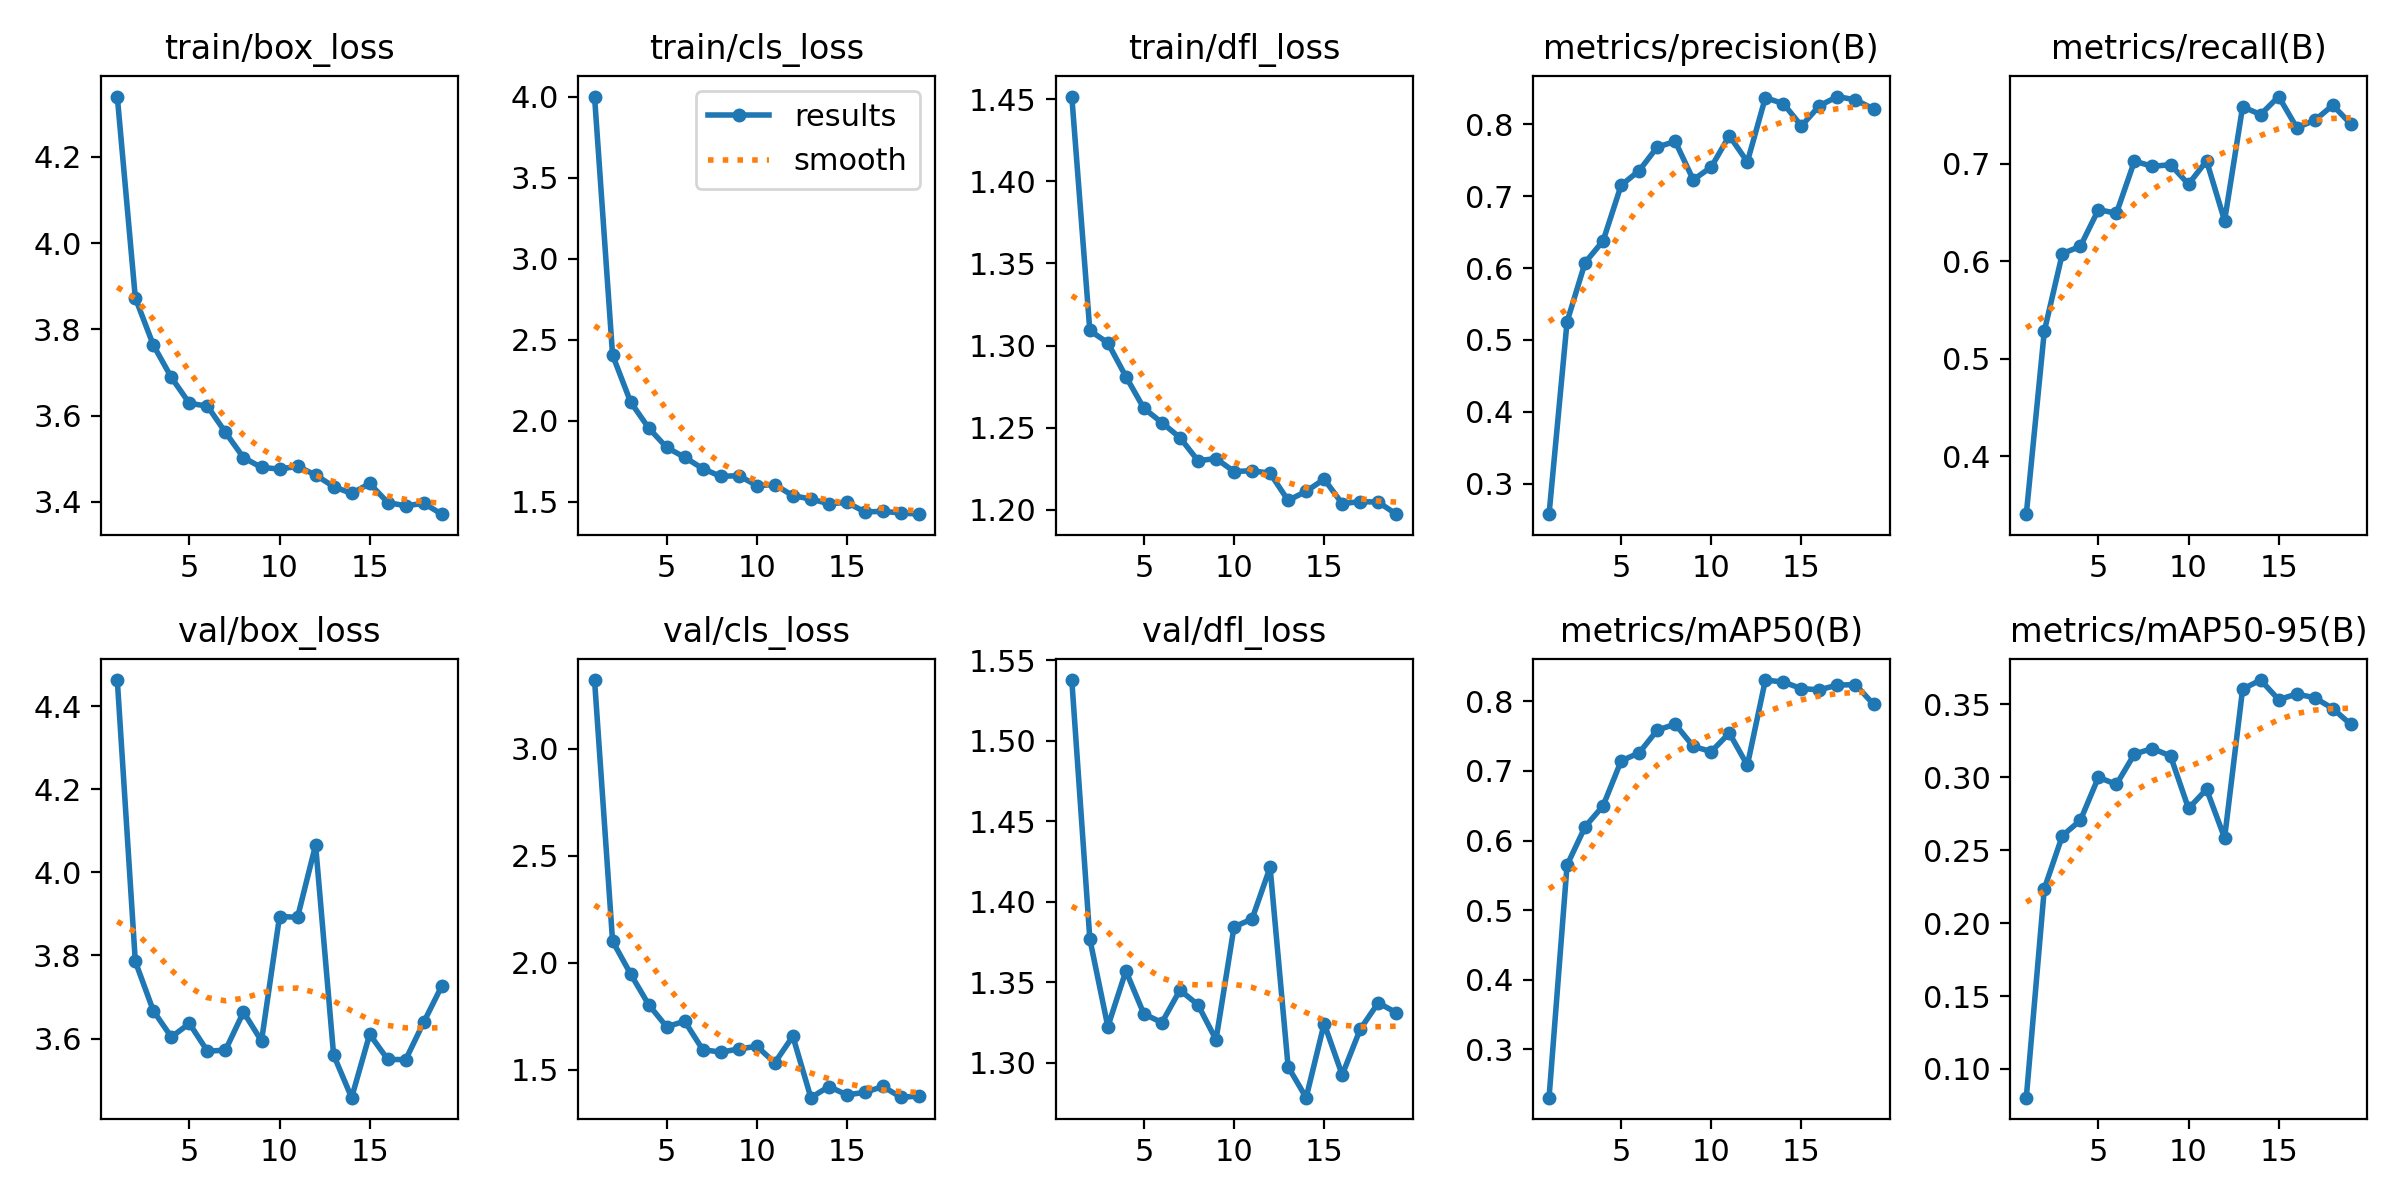

In [ ]:
Image(filename="runs/detect/yolov11_final_tuned_model2/results.png")

### Evaluacion del mejor modelo

In [ ]:
model = YOLO("runs/detect/yolov11_final_tuned_model2/weights/best.pt")

metrics = model.val(split='test')

Ultralytics 8.3.205  Python-3.12.11 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 5.25.1 ms, read: 0.40.3 MB/s, size: 17.2 KB)
val: Scanning G:\Mi unidad\Especilizacion IA\Bimestre 4\VPC II\Trabajo-Final-VPC2\dataset\test\labels... 883 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 883/883 21.6it/s 40.8s0.5ss
val: New cache created: G:\Mi unidad\Especilizacion IA\Bimestre 4\VPC II\Trabajo-Final-VPC2\dataset\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 9.5it/s 5.9s<0.1s
                   all        883        883       0.87      0.744      0.845      0.395
                     0        166        166      0.923      0.958      0.972      0.522
                     1        193        193      0.839      0.837      0.878      0.394
                     2        118    

In [ ]:
print("\n--- Métricas de Validación ---")
print(f"mAP50-95: {metrics.box.map}")
print(f"mAP50: {metrics.box.map50}")


--- Métricas de Validación ---
mAP50-95: 0.3945628779736954
mAP50: 0.8452069044944549


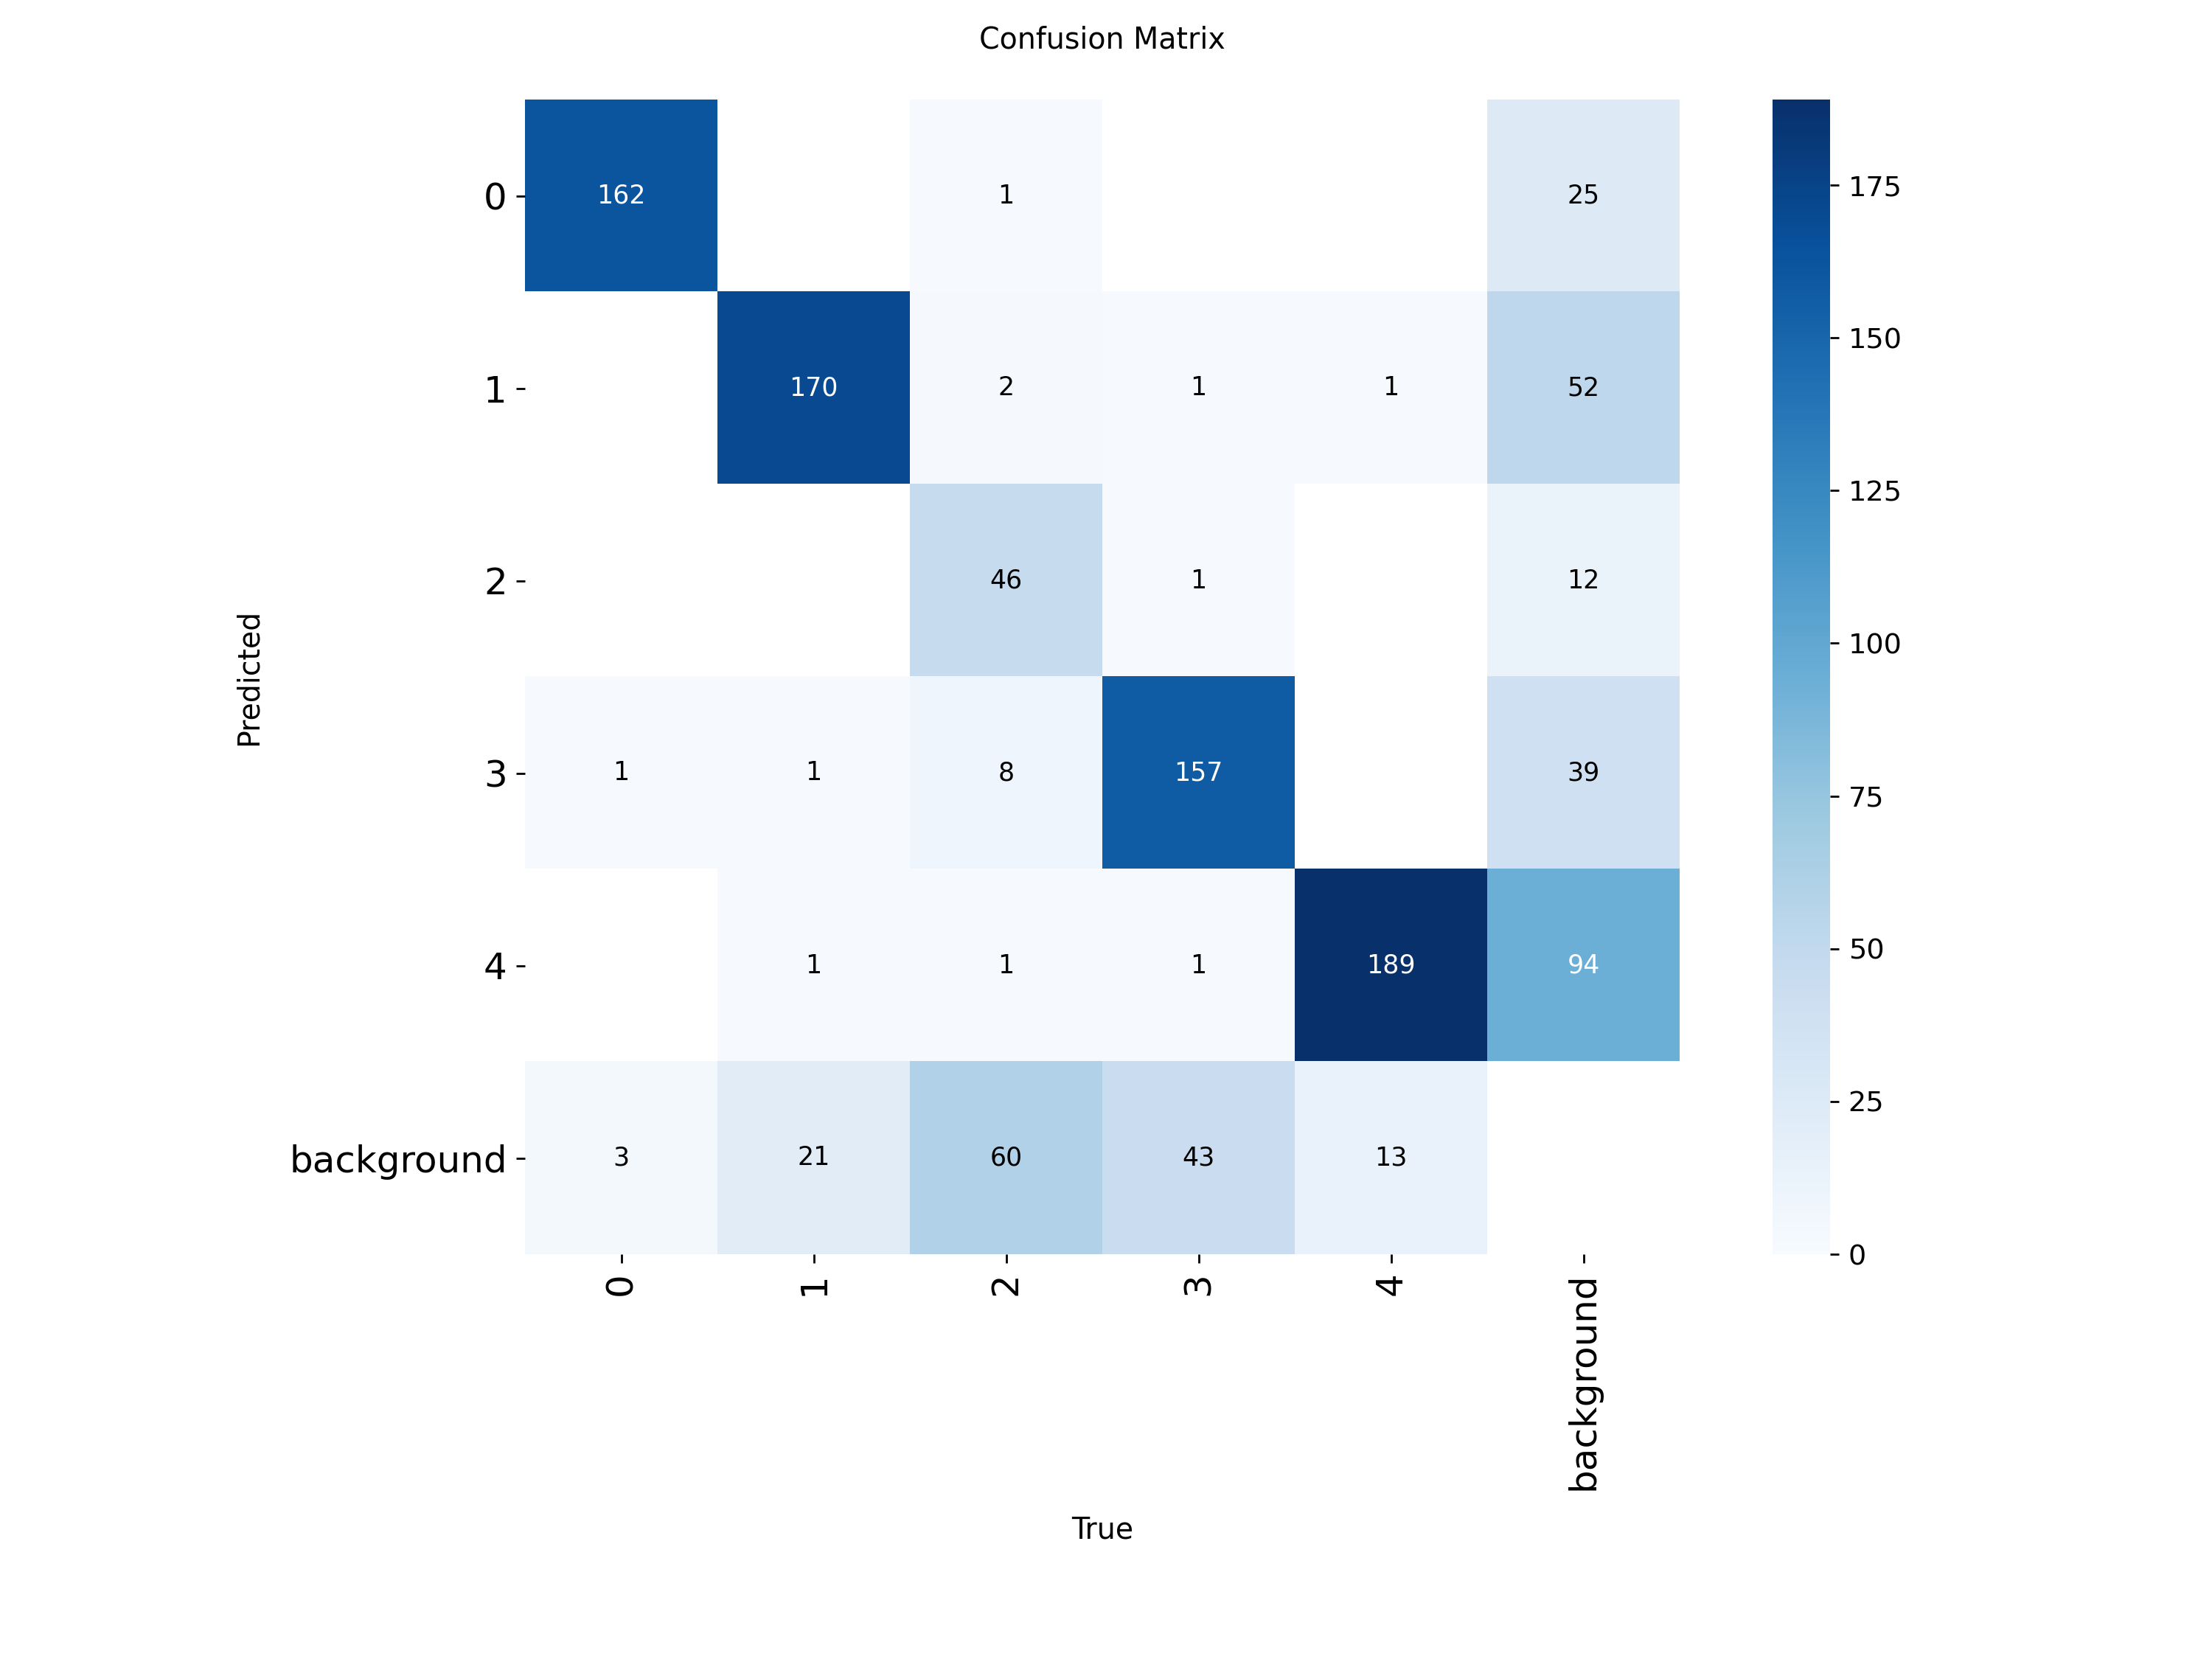

In [ ]:
Image(filename="runs/detect/val2/confusion_matrix.png")

El análisis de la matriz de confusión revela un rendimiento notablemente bueno para la mayoría de las clases. Sin embargo, la clase 2 presenta una excepción, ya que es confundida frecuentemente con otras, en especial con el fondo (background).

No obstante, se considera un modelo robusto que, en términos generales, logra identificar y clasificar los objetos de forma precisa en la mayoría de las situaciones.